### Variance Reduction Method
##### 1. Control variates 
##### 2. Antithetic variates
##### 3. Stratified sampling
##### 4. Latin hypercube sampling
##### 5. Moment matching methods
##### 6. Importance sampling 

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sst
import matplotlib.pyplot as plt
import QuantLib as ql

In [38]:
barrier_flag = 'DownOut'
optionflag = 'put'
s = 100  # t=0 시점 주가
k = 110  # 행사가
b = 80  # 옵션의 베리어
r = 0.03  # 무위험금리 (연속복리)
q = 0  # 배당
t = 1  # 옵션 만기 (in years)
sigma = 0.2  # 변동성
n = 10000  # 시뮬레이션 반복 횟수
m = 1000 # Time step의 수

### Analytic Solution

In [29]:
# Quantlib Analytic soulution
rebate = 0
barrierType = ql.Barrier.DownOut
optionType = ql.Option.Put

#Barrier Option
today = ql.Date().todaysDate()
maturity = today + ql.Period(t, ql.Years)

payoff = ql.PlainVanillaPayoff(optionType, k)
euExercise = ql.EuropeanExercise(maturity)
barrierOption = ql.BarrierOption(barrierType, b, rebate, payoff, euExercise)

#Market
spotHandle = ql.QuoteHandle(ql.SimpleQuote(s))
flatRateTs = ql.YieldTermStructureHandle(ql.FlatForward(today, r, ql.Actual365Fixed()))
flatVolTs = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, ql.NullCalendar(), sigma, ql.Actual365Fixed()))
bsm = ql.BlackScholesProcess(spotHandle, flatRateTs, flatVolTs)
analyticBarrierEngine = ql.AnalyticBarrierEngine(bsm)

#Pricing
barrierOption.setPricingEngine(analyticBarrierEngine)
price_as = barrierOption.NPV()

print("Analytic Price = ", price_as)

Analytic Price =  4.996852359577621


### Basic MC

In [30]:
def mc_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m):
    z = np.random.randn(n, m)
    st = np.zeros((n, m))
    st[:, 0] = s
    dt = t / m  
    
    # 각 time step에서 GBM 모델을 이용해 주가 변화율 계산
    schange = np.exp((r - q - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
    # 누적 곱을 이용해 시점별 주가 계산
    st[:, 1:] = s * np.cumprod(schange[:, 1:], axis=1)
    callOrPut = 1 if optionflag.lower()=='call' else -1
    
    # 베리어 조건
    knocked_in = np.zeros(n, dtype=bool)
    knocked_out = np.zeros(n, dtype=bool)
    # knocked_in과 knocked_out 배열을 np.where로 설정
    knocked_out = np.where(barrier_flag == 'UpOut', np.max(st, axis=1) >= b, knocked_out)
    knocked_in = np.where(barrier_flag == 'UpIn', np.max(st, axis=1) >= b, knocked_in)
    knocked_out = np.where(barrier_flag == 'DownOut', np.min(st, axis=1) <= b, knocked_out)
    knocked_in = np.where(barrier_flag == 'DownIn', np.min(st, axis=1) <= b, knocked_in)

    payoff = np.maximum(callOrPut * (st[:,-1] - k), 0)
    payoff = np.where('Out' in barrier_flag, np.where(knocked_out, 0, payoff), payoff)
    payoff = np.where('In' in barrier_flag, np.where(~knocked_in, 0, payoff), payoff)

    # 현재가치로 할인한 만기 페이오프의 기댓값 계산    
    discounted_payoff = np.exp(-r * t) * payoff
    price = np.mean(discounted_payoff)
    se = discounted_payoff.std(ddof=1) / np.sqrt(n)
    return price, se

#Analytic Price와 Montecarlo simulation price 오차 계산
price_ms, se_ms = mc_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
# pricediff = price_as - price_ms

print(f"Monte Carlo Barrier Option Price = {price_ms:.6f} / se = {se_ms:0.6f}")
# print("Analytic Price = ", price_as)
# print(f"Price difference = {pricediff:.6f}")

Monte Carlo Barrier Option Price = 5.211182 / se = 0.076066


### 1. Control Variates

In [40]:
#Plain Vanilla
def CV1_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m):
    # MC European plain vanilla option
    z = np.random.randn(n,m)
    st = np.zeros((n, m))
    st[:, 0] = s
    dt = t / m
    ds = np.exp((r - q - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
    st[:, 1:] = s * np.cumprod(ds[:, 1:], axis=1)
    callOrPut = 1 if optionflag.lower()=='call' else -1    
    payoff = np.maximum(callOrPut*(st[:, -1]-k), 0)    
    vanilla_disc_payoff = np.exp(-r*t)*payoff
    
    #E[X]를 계산하기 위한 유러피안 콜옵션의 애널리틱 가격
    d1 = (np.log(s/k) + (r - q + 0.5*sigma**2)*t) / (sigma*np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)
    nd1 = sst.norm.cdf(callOrPut*d1)
    nd2 = sst.norm.cdf(callOrPut*d2)
    price_analytic_BS = callOrPut*(s*np.exp(-q*t)*nd1 - k*np.exp(-r*t)*nd2)
    
    # 베리어 조건
    knocked_in = np.zeros(n, dtype=bool)
    knocked_out = np.zeros(n, dtype=bool)
    knocked_out = np.where(barrier_flag == 'UpOut', np.max(st, axis=1) >= b, knocked_out)
    knocked_in = np.where(barrier_flag == 'UpIn', np.max(st, axis=1) >= b, knocked_in)
    knocked_out = np.where(barrier_flag == 'DownOut', np.min(st, axis=1) <= b, knocked_out)
    knocked_in = np.where(barrier_flag == 'DownIn', np.min(st, axis=1) <= b, knocked_in)

    payoff = np.maximum(callOrPut * (st[:,-1] - k), 0)
    payoff = np.where('Out' in barrier_flag, np.where(knocked_out, 0, payoff), payoff)
    payoff = np.where('In' in barrier_flag, np.where(~knocked_in, 0, payoff), payoff)

    # 현재가치로 할인한 만기 페이오프의 기댓값 계산    
    discounted_payoff = np.exp(-r * t) * payoff

    c = np.cov((discounted_payoff, vanilla_disc_payoff), ddof=1)    
    cv_disc_payoff = discounted_payoff - c[1,0]/c[1,1]*(vanilla_disc_payoff - price_analytic_BS )
    #공분산/분산 : c[1,0]/c[1,1]
    cv_price = cv_disc_payoff.mean()
    cv_se = cv_disc_payoff.std(ddof=1) / np.sqrt(n)

    return cv_price, cv_se 

price_ms, se_ms = mc_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
price_CV1, se_CV1 = CV1_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)

print(f"Monte Carlo Barrier Option Price = {price_ms:.6f} / se = {se_ms:0.6f}")
print(f"CV1 Price = {price_CV1:0.6f} / se_CV1 = {se_CV1:0.6f}")

Monte Carlo Barrier Option Price = 5.222089 / se = 0.075934
CV1 Price = 5.220329 / se_CV1 = 0.074453


In [39]:
#Underlying asset, ITM(k=70): 0.017, ATM: 0.089, OTM(k=130): 0.068

def CV2_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m):
    #European plain vanilla option
    z = np.random.randn(n,m)
    st = np.zeros((n, m))
    st[:, 0] = s
    dt = t / m
    ds = np.exp((r - q - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
    st[:, 1:] = s * np.cumprod(ds[:, 1:], axis=1)
    callOrPut = 1 if optionflag.lower()=='call' else -1    
    
    # 베리어 조건
    knocked_in = np.zeros(n, dtype=bool)
    knocked_out = np.zeros(n, dtype=bool)
    knocked_out = np.where(barrier_flag == 'UpOut', np.max(st, axis=1) >= b, knocked_out)
    knocked_in = np.where(barrier_flag == 'UpIn', np.max(st, axis=1) >= b, knocked_in)
    knocked_out = np.where(barrier_flag == 'DownOut', np.min(st, axis=1) <= b, knocked_out)
    knocked_in = np.where(barrier_flag == 'DownIn', np.min(st, axis=1) <= b, knocked_in)

    payoff = np.maximum(callOrPut * (st[:,-1] - k), 0)
    payoff = np.where('Out' in barrier_flag, np.where(knocked_out, 0, payoff), payoff)
    payoff = np.where('In' in barrier_flag, np.where(~knocked_in, 0, payoff), payoff)

    # 현재가치로 할인한 만기 페이오프의 기댓값 계산    
    discounted_payoff = np.exp(-r * t) * payoff
    price = np.mean(discounted_payoff)
    se = discounted_payoff.std(ddof=1) / np.sqrt(n)

    #기초자산가격의 종가와 페이오프 간의 분산공분산 (둘다 1차원)
    c = np.cov((discounted_payoff, st[:, -1]), ddof=1)    
    cv_disc_payoff = discounted_payoff - c[1,0]/c[1,1]*(st[:, -1]-s*np.exp((r-q)*t)) 
    #공분산/분산 : c[1,0]/c[1,1]
    cv_price = cv_disc_payoff.mean()
    cv_se = cv_disc_payoff.std(ddof=1) / np.sqrt(n)

    return cv_price, cv_se 

price_CV2, se_CV2 = CV2_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)

print(f"CV2 Price = {price_CV2:0.6f} / se_CV2 = {se_CV2:0.6f}")

CV2 Price = 5.091262 / se_CV2 = 0.071164


### 2. Antithetic Variates

In [41]:
def AV_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m):
    n_half = n // 2
    z_half = np.random.randn(n_half, m) 
    z_antithetic = -z_half
    z = np.vstack([z_half, z_antithetic])
    st = np.zeros((n, m))
    st[:, 0] = s
    dt = t / m  
    
    # 각 time step에서 GBM 모델을 이용해 주가 변화율 계산
    schange = np.exp((r - q - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
    # 누적 곱을 이용해 시점별 주가 계산
    st[:, 1:] = s * np.cumprod(schange[:, 1:], axis=1)
    callOrPut = 1 if optionflag.lower()=='call' else -1
    
    # 베리어 조건
    knocked_in = np.zeros(n, dtype=bool)
    knocked_out = np.zeros(n, dtype=bool)
    # knocked_in과 knocked_out 배열을 np.where로 설정
    knocked_out = np.where(barrier_flag == 'UpOut', np.max(st, axis=1) >= b, knocked_out)
    knocked_in = np.where(barrier_flag == 'UpIn', np.max(st, axis=1) >= b, knocked_in)
    knocked_out = np.where(barrier_flag == 'DownOut', np.min(st, axis=1) <= b, knocked_out)
    knocked_in = np.where(barrier_flag == 'DownIn', np.min(st, axis=1) <= b, knocked_in)

    #페이오프 계산
    payoff = np.maximum(callOrPut * (st[:,-1] - k), 0)
    payoff = np.where('Out' in barrier_flag, np.where(knocked_out, 0, payoff), payoff)
    payoff = np.where('In' in barrier_flag, np.where(~knocked_in, 0, payoff), payoff)

    # 현재가치로 할인한 만기 페이오프의 기댓값 계산    
    discounted_payoff = np.exp(-r * t) * payoff
    price = np.mean(discounted_payoff)
    se = discounted_payoff.std(ddof=1) / np.sqrt(n)

    return price, se

price_AV, se_AV = AV_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)

print(f"Antithetic Price = {price_AV:0.6f} / se_AV = {se_AV:0.6f}")

Antithetic Price = 5.158983 / se_AV = 0.076299


### 3. Stratified Sampling

### 4. Latin Hypercube Sampling

In [42]:
from scipy.stats import norm

# 라틴 하이퍼큐브 샘플링 함수
def latin_hypercube_sampling(n, d):
    result = np.zeros((n, d))
    for j in range(d):
        #1부터 n까지의 값을 임의로 섞은 배열을 반환
        perm = np.random.permutation(n) + 1
        #배열방식을 모든 열에 적용
        result[:, j] = (perm - np.random.rand(n)) / n
    return result

def LHS_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m):
    
    dt = t / m
    callOrPut = 1 if optionflag.lower() == 'call' else -1  
    
    # 라틴 하이퍼큐브 샘플링을 이용해 표준 정규분포 샘플 생성
    lhs_samples = latin_hypercube_sampling(n, m)
    z = norm.ppf(lhs_samples)  # 정규분포로 변환
    st = np.zeros((n, m))
    st[:, 0] = s
    for i in range(1, m):
        schange = np.exp((r - q - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z[:, i])
        st[:, i] = st[:, i - 1] * schange  # 누적 곱 계산
    
    # 베리어 옵션 조건
    knocked_in = np.zeros(n, dtype=bool)
    knocked_out = np.zeros(n, dtype=bool)
    knocked_out = np.where(barrier_flag == 'UpOut', np.max(st, axis=1) >= b, knocked_out)
    knocked_in = np.where(barrier_flag == 'UpIn', np.max(st, axis=1) >= b, knocked_in)
    knocked_out = np.where(barrier_flag == 'DownOut', np.min(st, axis=1) <= b, knocked_out)
    knocked_in = np.where(barrier_flag == 'DownIn', np.min(st, axis=1) <= b, knocked_in)

    #페이오프 계산
    payoff = np.maximum(callOrPut * (st[:,-1] - k), 0)
    payoff = np.where('Out' in barrier_flag, np.where(knocked_out, 0, payoff), payoff)
    payoff = np.where('In' in barrier_flag, np.where(~knocked_in, 0, payoff), payoff)

    # 현재가치로 할인한 만기 페이오프의 기댓값 계산    
    discounted_payoff = np.exp(-r * t) * payoff
    price = np.mean(discounted_payoff)
    se = discounted_payoff.std(ddof=1) / np.sqrt(n)
    
    return price, se

barrier_flag = 'DownOut'
optionflag = 'put'
s = 100  # t=0 시점 주가
k = 110  # 행사가
b = 80  # 옵션의 베리어
r = 0.03  # 무위험금리 (연속복리)
q = 0  # 배당
t = 1  # 옵션 만기 (in years)
sigma = 0.2  # 변동성
n = 10000  # 시뮬레이션 반복 횟수
m = 1000 # Time step의 수

price_lhs, se_lhs = LHS_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
print(f"Monte Carlo Barrier Option Price with LHS = {price_lhs:.6f} / se = {se_lhs:.6f}")


Monte Carlo Barrier Option Price with LHS = 5.141061 / se = 0.076152


In [13]:
perm = np.random.permutation(n) + 1
pd.DataFrame(perm)

,0
0,6145
1,454
2,9819
3,6802
4,8926
...,...
9995,8369
9996,6759
9997,9148
9998,1276


In [14]:
d = 100
result = np.zeros((n, d))
perm = np.random.permutation(n) + 1
result[:, 99] = (perm - np.random.rand(n)) / n

df = pd.DataFrame(result)
df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.714475
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.604374
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.720653
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.434265
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.063354
9996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.258836
9997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.150258
9998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.700361


In [15]:
duplicate_values = df[df.duplicated(subset=[99], keep=False)]  # 중복된 행을 모두 표시

# 중복된 값과 그 행을 출력
if not duplicate_values.empty:
    print("중복된 값이 있는 행들:")
    print(duplicate_values)
else:
    print("중복된 값이 없습니다.")

중복된 값이 없습니다.


In [16]:
d = 100
result = np.zeros((n, d))
for j in range(d):
    #1부터 n까지의 값을 임의로 섞은 배열을 반환
    perm = np.random.permutation(n) + 1
    result[:, j] = (perm - np.random.rand(n)) / n

pd.DataFrame(result)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.958371,0.459477,0.809263,0.571622,0.811037,0.473339,0.860109,0.905304,0.621027,0.805384,...,0.304392,0.153866,0.706075,0.288564,0.450548,0.237551,0.108361,0.641961,0.455354,0.810145
1,0.767763,0.296823,0.747426,0.791549,0.319936,0.860450,0.826982,0.544930,0.991059,0.824446,...,0.922198,0.788745,0.436248,0.008789,0.726291,0.337752,0.427365,0.991788,0.577049,0.941171
2,0.581174,0.826933,0.520729,0.998234,0.927618,0.456837,0.408814,0.342786,0.329406,0.108169,...,0.919658,0.334940,0.637511,0.240422,0.492953,0.139137,0.268363,0.013802,0.741103,0.908713
3,0.271827,0.057710,0.802583,0.766208,0.510998,0.012353,0.672576,0.782926,0.520594,0.171322,...,0.786924,0.288326,0.824122,0.986359,0.524883,0.356044,0.577753,0.104648,0.833395,0.646558
4,0.731786,0.643634,0.182678,0.748912,0.275011,0.476155,0.791903,0.109430,0.527128,0.631307,...,0.359092,0.015389,0.058408,0.751025,0.492232,0.657237,0.919039,0.109704,0.329077,0.905982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.971232,0.802439,0.347041,0.257438,0.572165,0.878198,0.295190,0.095679,0.639814,0.689659,...,0.190438,0.494650,0.870744,0.447770,0.200937,0.238428,0.237770,0.783707,0.900291,0.938730
9996,0.731057,0.225072,0.653544,0.832390,0.808831,0.584920,0.020484,0.329915,0.841267,0.380073,...,0.188910,0.313331,0.301516,0.141447,0.826283,0.380491,0.790446,0.541188,0.205185,0.165020
9997,0.751633,0.045885,0.120816,0.606151,0.261422,0.765021,0.039054,0.044307,0.551553,0.442269,...,0.015710,0.485926,0.908725,0.017059,0.671695,0.599962,0.022686,0.918516,0.451687,0.937790
9998,0.170340,0.091428,0.643511,0.849942,0.773050,0.605982,0.637712,0.699120,0.576629,0.283652,...,0.596373,0.136379,0.475389,0.061704,0.377708,0.414273,0.596957,0.798850,0.034237,0.314839


### 5. Weighted MC Moment Matching Method + CV

In [50]:
import numpy as np
import scipy.stats as sst
def analytic_barrier_price(s, k, b, r, t, sigma):
    rebate = 0
    barrierType = ql.Barrier.DownIn
    optionType = ql.Option.Call

    #Barrier Option
    today = ql.Date().todaysDate()
    maturity = today + ql.Period(t, ql.Years)

    payoff = ql.PlainVanillaPayoff(optionType, k)
    euExercise = ql.EuropeanExercise(maturity)
    barrierOption = ql.BarrierOption(barrierType, b, rebate, payoff, euExercise)

    #Market
    spotHandle = ql.QuoteHandle(ql.SimpleQuote(s))
    flatRateTs = ql.YieldTermStructureHandle(ql.FlatForward(today, r, ql.Actual365Fixed()))
    flatVolTs = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, ql.NullCalendar(), sigma, ql.Actual365Fixed()))
    bsm = ql.BlackScholesProcess(spotHandle, flatRateTs, flatVolTs)
    analyticBarrierEngine = ql.AnalyticBarrierEngine(bsm)

    #Pricing
    barrierOption.setPricingEngine(analyticBarrierEngine)
    price_as = barrierOption.NPV()
    return price_as

def CVMM_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m):
    # MC European plain vanilla option
    z = np.random.randn(n,m)
    st = np.zeros((n, m))
    st[:, 0] = s
    dt = t / m
    ds = np.exp((r - q - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
    st[:, 1:] = s * np.cumprod(ds[:, 1:], axis=1)
    callOrPut = 1 if optionflag.lower()=='call' else -1    
    payoff1 = np.maximum(callOrPut*(st[:, -1]-k), 0)    
    vanilla_disc_payoff = np.exp(-r*t)*payoff1
    
    # Calculate the analytic price using Black-Scholes for moment matching
    d1 = (np.log(s/k) + (r - q + 0.5*sigma**2)*t) / (sigma*np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)
    nd1 = sst.norm.cdf(callOrPut*d1)
    nd2 = sst.norm.cdf(callOrPut*d2)
    price_analytic_BS = callOrPut*(s*np.exp(-q*t)*nd1 - k*np.exp(-r*t)*nd2)
    
    # Barrier conditions
    knocked_in = np.zeros(n, dtype=bool)
    knocked_out = np.zeros(n, dtype=bool)
    knocked_out = np.where(barrier_flag == 'UpOut', np.max(st, axis=1) >= b, knocked_out)
    knocked_in = np.where(barrier_flag == 'UpIn', np.max(st, axis=1) >= b, knocked_in)
    knocked_out = np.where(barrier_flag == 'DownOut', np.min(st, axis=1) <= b, knocked_out)
    knocked_in = np.where(barrier_flag == 'DownIn', np.min(st, axis=1) <= b, knocked_in)

    payoff = np.maximum(callOrPut * (st[:,-1] - k), 0)
    payoff = np.where('Out' in barrier_flag, np.where(knocked_out, 0, payoff), payoff)
    payoff = np.where('In' in barrier_flag, np.where(~knocked_in, 0, payoff), payoff)
    
    # Moment matching - adjusting weights to match expected value
    weights = np.ones(n)
    X_weighted = np.sum(weights * vanilla_disc_payoff) / n  # Calculate weighted average
    adjustment_factor = price_analytic_BS / X_weighted  # Adjust to match analytic price
    weights *= adjustment_factor  # Adjust weights
    
    # Apply the weighted payoff calculation
    discounted_payoff = np.exp(-r * t) * payoff
    
    # Control variate method for variance reduction    
    c = np.cov((discounted_payoff, vanilla_disc_payoff), ddof=1)    
    cv_disc_payoff = discounted_payoff - c[1,0]/c[1,1]*(vanilla_disc_payoff - price_analytic_BS )
    weighted_discounted_payoff = np.exp(-r * t) * cv_disc_payoff * weights
    weighted_price = np.sum(weighted_discounted_payoff) / np.sum(weights)
    cvmm_se = weighted_discounted_payoff.std(ddof=1) / np.sqrt(n)

    return weighted_price, cvmm_se

barrier_flag = 'DownIn'
optionflag = 'call'
s = 100  # t=0 시점 주가
k = 100  # 행사가
b = 85  # 옵션의 베리어
r = 0.03  # 무위험금리 (연속복리)
q = 0  # 배당
t = 1  # 옵션 만기 (in years)
sigma = 0.2  # 변동성
n = 10000  # 시뮬레이션 반복 횟수
m = 1000 # Time step의 수
price_as = analytic_barrier_price(s, k, b, r, t, sigma)
price_CVMM, se_CVMM = CVMM_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
price_CV1, se_CV1 = CV1_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
price_ms, se_ms = mc_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)

print(price_as)
print(f"Monte Carlo Barrier Option Price = {price_ms:.6f} / se = {se_ms:0.6f}")
print(f"CV1 Price = {price_CV1:0.6f} / se_CV1 = {se_CV1:0.6f}")
print(f"CVMM Price = {price_CVMM:0.6f} / se_CVMM = {se_CVMM:0.6f}")

0.476990085939315
Monte Carlo Barrier Option Price = 0.426565 / se = 0.025466
CV1 Price = 0.419393 / se_CV1 = 0.025629
CVMM Price = 0.405208 / se_CVMM = 0.024270


### CV + Moment Matching with Z1, Z2

In [52]:
import numpy as np
import scipy.stats as sst

def analytic_barrier_price(s, k, b, r, t, sigma):
    rebate = 0
    barrierType = ql.Barrier.DownOut
    optionType = ql.Option.Call

    #Barrier Option
    today = ql.Date().todaysDate()
    maturity = today + ql.Period(t, ql.Years)

    payoff = ql.PlainVanillaPayoff(optionType, k)
    euExercise = ql.EuropeanExercise(maturity)
    barrierOption = ql.BarrierOption(barrierType, b, rebate, payoff, euExercise)

    #Market
    spotHandle = ql.QuoteHandle(ql.SimpleQuote(s))
    flatRateTs = ql.YieldTermStructureHandle(ql.FlatForward(today, r, ql.Actual365Fixed()))
    flatVolTs = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, ql.NullCalendar(), sigma, ql.Actual365Fixed()))
    bsm = ql.BlackScholesProcess(spotHandle, flatRateTs, flatVolTs)
    analyticBarrierEngine = ql.AnalyticBarrierEngine(bsm)

    #Pricing
    barrierOption.setPricingEngine(analyticBarrierEngine)
    price_as = barrierOption.NPV()
    return price_as

def CVMM2_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m):
    # Generate standard normal random variables
    z = np.random.randn(n, m)
    z_mean = np.mean(z, axis=0)
    z_std = np.std(z, axis=0, ddof=1)

    # Adjust Z to ensure correct moments (equivalent to W_i(tk) in the image)
    z_adj = (z - z_mean) / z_std
    st = np.zeros((n, m))
    st[:, 0] = s
    dt = t / m
    ds = np.exp((r - q - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z_adj)
    st[:, 1:] = s * np.cumprod(ds[:, 1:], axis=1)
    
    callOrPut = 1 if optionflag.lower() == 'call' else -1    
    payoff = np.maximum(callOrPut * (st[:, -1] - k), 0)    
    vanilla_disc_payoff = np.exp(-r * t) * payoff
    
    # Calculate the analytic price using Black-Scholes
    d1 = (np.log(s / k) + (r - q + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))
    d2 = d1 - sigma * np.sqrt(t)
    nd1 = sst.norm.cdf(callOrPut * d1)
    nd2 = sst.norm.cdf(callOrPut * d2)
    price_analytic_BS = callOrPut * (s * np.exp(-q * t) * nd1 - k * np.exp(-r * t) * nd2)
    
    # Barrier conditions
    knocked_in = np.zeros(n, dtype=bool)
    knocked_out = np.zeros(n, dtype=bool)
    knocked_out = np.where(barrier_flag == 'UpOut', np.max(st, axis=1) >= b, knocked_out)
    knocked_in = np.where(barrier_flag == 'UpIn', np.max(st, axis=1) >= b, knocked_in)
    knocked_out = np.where(barrier_flag == 'DownOut', np.min(st, axis=1) <= b, knocked_out)
    knocked_in = np.where(barrier_flag == 'DownIn', np.min(st, axis=1) <= b, knocked_in)

    payoff = np.maximum(callOrPut * (st[:, -1] - k), 0)
    payoff = np.where('Out' in barrier_flag, np.where(knocked_out, 0, payoff), payoff)
    payoff = np.where('In' in barrier_flag, np.where(~knocked_in, 0, payoff), payoff)

    # Discounted payoff
    discounted_payoff = np.exp(-r * t) * payoff

    # Control variate method for variance reduction    
    c = np.cov((discounted_payoff, vanilla_disc_payoff), ddof=1)    
    cv_disc_payoff = discounted_payoff - c[1, 0] / c[1, 1] * (vanilla_disc_payoff - price_analytic_BS)
    
    cv_price = cv_disc_payoff.mean()
    cv_se = cv_disc_payoff.std(ddof=1) / np.sqrt(n)

    return cv_price, cv_se 


barrier_flag = 'DownOut'
optionflag = 'call'
s = 100  # t=0 시점 주가
k = 100  # 행사가
b = 90  # 옵션의 베리어
r = 0.03  # 무위험금리 (연속복리)
q = 0  # 배당
t = 1  # 옵션 만기 (in years)
sigma = 0.2  # 변동성
n = 10000  # 시뮬레이션 반복 횟수
m = 1000 # Time step의 수
price_as = analytic_barrier_price(s, k, b, r, t, sigma)
price_CVMM2, se_CVMM2 = CVMM2_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
price_CV1, se_CV1 = CV1_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
price_ms, se_ms = mc_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)

print(price_as)
print(f"Monte Carlo Barrier Option Price = {price_ms:.6f} / se = {se_ms:0.6f}")
print(f"CV1 Price = {price_CV1:0.6f} / se_CV1 = {se_CV1:0.6f}")
print(f"CVMM2 Price = {price_CVMM2:0.6f} / se_CVMM2 = {se_CVMM2:0.6f}")

7.740220606646414
Monte Carlo Barrier Option Price = 7.698704 / se = 0.136001
CV1 Price = 7.831718 / se_CV1 = 0.053545
CVMM2 Price = 7.870127 / se_CVMM2 = 0.052690


In [523]:
import numpy as np
import scipy.stats as sst
from sklearn.linear_model import LinearRegression

def analytic_barrier_price(s, k, b, r, t, sigma):
    rebate = 0
    barrierType = ql.Barrier.DownIn
    optionType = ql.Option.Call

    #Barrier Option
    today = ql.Date().todaysDate()
    maturity = today + ql.Period(t, ql.Years)

    payoff = ql.PlainVanillaPayoff(optionType, k)
    euExercise = ql.EuropeanExercise(maturity)
    barrierOption = ql.BarrierOption(barrierType, b, rebate, payoff, euExercise)

    #Market
    spotHandle = ql.QuoteHandle(ql.SimpleQuote(s))
    flatRateTs = ql.YieldTermStructureHandle(ql.FlatForward(today, r, ql.Actual365Fixed()))
    flatVolTs = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, ql.NullCalendar(), sigma, ql.Actual365Fixed()))
    bsm = ql.BlackScholesProcess(spotHandle, flatRateTs, flatVolTs)
    analyticBarrierEngine = ql.AnalyticBarrierEngine(bsm)

    #Pricing
    barrierOption.setPricingEngine(analyticBarrierEngine)
    price_as = barrierOption.NPV()
    return price_as


# Test parameters
barrier_flag = 'DownIn'
optionflag = 'call'
s = 100  # Initial stock price
k = 100  # Strike price
b = 90  # Barrier level
r = 0.03  # Risk-free rate
q = 0  # Dividend yield
t = 1  # Time to maturity (in years)
sigma = 0.2  # Volatility
n = 10000  # Number of simulations
m = 2000  # Number of time steps

# Calculate the prices
price_as = analytic_barrier_price(s, k, b, r, t, sigma)
price_CVMM, se_CVMM = CVMM_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
price_CV1, se_CVMM = CV1_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
price_ms, se_ms = mc_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)

print(price_as)
print(f"Monte Carlo Barrier Option Price = {price_ms:.6f} / se = {se_ms:0.6f}")
print(f"CV1 Price = {price_CV1:0.6f} / se_CV1 = {se_CV1:0.6f}")
print(f"CVMM Price = {price_CVMM:0.6f} / se_CVMM = {se_CVMM:0.6f}")


1.673182777206609
Monte Carlo Barrier Option Price = 1.427143 / se = 0.049848
CV1 Price = 1.558552 / se_CV1 = 0.052292
CVMM Price = 1.602445 / se_CVMM = 0.053701


### 6. Importance Sampling

In [58]:
import numpy as np
def IS_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m):
    z = np.random.randn(n, m)
    st = np.zeros((n, m))
    st[:, 0] = s
    dt = t / m  

    #importance sampling
    mu = (np.log(k/s) - (r-q-0.5*sigma**2)*t) / (sigma*np.sqrt(t))
    #S(T)=K이도록 하는 뮤
    z += mu #평균이 뮤, 원래 평균은 0
    likelihood_ratio = np.exp(-mu*np.sum(z, axis=1, keepdims=True) + 0.5*m*mu**2)

    schange = np.exp((r - q - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
    st[:, 1:] = s * np.cumprod(schange[:, 1:], axis=1)
    callOrPut = 1 if optionflag.lower()=='call' else -1

    # 베리어 조건
    knocked_in = np.zeros(n, dtype=bool)
    knocked_out = np.zeros(n, dtype=bool)
    # knocked_in과 knocked_out 배열을 np.where로 설정
    knocked_out = np.where(barrier_flag == 'UpOut', np.max(st, axis=1) >= b, knocked_out)
    knocked_in = np.where(barrier_flag == 'UpIn', np.max(st, axis=1) >= b, knocked_in)
    knocked_out = np.where(barrier_flag == 'DownOut', np.min(st, axis=1) <= b, knocked_out)
    knocked_in = np.where(barrier_flag == 'DownIn', np.min(st, axis=1) <= b, knocked_in)

    payoff = np.maximum(callOrPut * (st[:,-1] - k), 0)
    payoff = np.where('Out' in barrier_flag, np.where(knocked_out, 0, payoff), payoff)
    payoff = np.where('In' in barrier_flag, np.where(~knocked_in, 0, payoff), payoff)

    # 현재가치로 할인한 만기 페이오프의 기댓값 계산

    disc_payoff = np.exp(-r*t)*np.dot(payoff,likelihood_ratio)
    price = (disc_payoff/n)[0]
    likelihood_ratio=likelihood_ratio.flatten()
    se = (payoff*likelihood_ratio).std(ddof=1) / np.sqrt(n)

    return price, se, st.mean()


#ATM f와g가 크게 다르지않음
#k를 90인 OTM으로 설정하면, 3개월동안 10프로 떨어지는 확률이 그렇게 크지않음(변동성 0.25, 3개월주기)
#IS SE가 일반 MC보다 3배 적음, 같은효과를 얻으려면 MC 샘플수를 9배 늘려야됨(시간 9배)
#조금 더 deep otm으로 가면, SE가 1/5됨
#k를 110 ITM으로 설정하면, h*f가 둘다 작아짐(hf최대화 원함)
#분산 4배됨
barrier_flag = 'DownOut'
optionflag = 'call'
s = 100  # t=0 시점 주가
k = 100  # 행사가
b = 70  # 옵션의 베리어
r = 0.03  # 무위험금리 (연속복리)
q = 0  # 배당
t = 1  # 옵션 만기 (in years)
sigma = 0.2  # 변동성
n = 10000  # 시뮬레이션 반복 횟수
m = 100 # Time step의 수



price_IS, se_IS, mu = IS_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
print(f"IS Price = {price_IS:0.6f} / se_IS = {se_IS:0.6f}")
print("-"*50)
print(mu)

IS Price = 9.571030 / se_IS = 0.285725
--------------------------------------------------
96.65673125260723


In [41]:
z = np.random.randn(n, m)
st = np.zeros((n, m))
st[:, 0] = s
dt = t / m  

#importance sampling
mu = (np.log(k/s) - (r-q-0.5*sigma**2)*t) / (sigma*np.sqrt(t))
#S(T)=K이도록 하는 뮤
z += mu #평균이 뮤, 원래 평균은 0
likelihood_ratio = np.exp(-mu*np.sum(z, axis=1, keepdims=True) + 0.5*m*mu**2)

schange = np.exp((r - q - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
st[:, 1:] = s * np.cumprod(schange[:, 1:], axis=1)
callOrPut = 1 if optionflag.lower()=='call' else -1

# 베리어 조건
knocked_in = np.zeros(n, dtype=bool)
knocked_out = np.zeros(n, dtype=bool)
# knocked_in과 knocked_out 배열을 np.where로 설정
knocked_out = np.where(barrier_flag == 'UpOut', np.max(st, axis=1) >= b, knocked_out)
knocked_in = np.where(barrier_flag == 'UpIn', np.max(st, axis=1) >= b, knocked_in)
knocked_out = np.where(barrier_flag == 'DownOut', np.min(st, axis=1) <= b, knocked_out)
knocked_in = np.where(barrier_flag == 'DownIn', np.min(st, axis=1) <= b, knocked_in)

payoff = np.maximum(callOrPut * (st[:,-1] - k), 0)
payoff = np.where('Out' in barrier_flag, np.where(knocked_out, 0, payoff), payoff)
payoff = np.where('In' in barrier_flag, np.where(~knocked_in, 0, payoff), payoff)

# 현재가치로 할인한 만기 페이오프의 기댓값 계산
    
disc_payoff = np.exp(-r*t)*np.dot(payoff,likelihood_ratio)
price = (disc_payoff/n)[0]
likelihood_ratio=likelihood_ratio.flatten()
se = (payoff*likelihood_ratio).std(ddof=1) / np.sqrt(n)
price_ms, se_ms = mc_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)

barrier_flag = 'DownOut'
optionflag = 'put'
s = 100  # t=0 시점 주가
k = 110  # 행사가
b = 80  # 옵션의 베리어
r = 0.03  # 무위험금리 (연속복리)
q = 0  # 배당
t = 1  # 옵션 만기 (in years)
sigma = 0.3  # 변동성
n = 9000  # 시뮬레이션 반복 횟수
m = 1000 # Time step의 수

print(price, se)
print(price_ms, se_ms)
print(price_as)

0.0 0.0
2.5390432959970806 0.06251035292230077
0.6084349501171071


In [47]:
z = np.random.randn(n, m)
st = np.zeros((n, m))
st[:, 0] = s
dt = t / m  

#importance sampling
mu = (np.log(k/s) - (r-q-0.5*sigma**2)*t) / (sigma*np.sqrt(t))
#S(T)=K이도록 하는 뮤
z += mu #평균이 뮤, 원래 평균은 0
likelihood_ratio = np.exp(-mu*np.sum(z, axis=1, keepdims=True) + 0.5*m*mu**2)

schange = np.exp((r - q - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
st[:, 1:] = s * np.cumprod(schange[:, 1:], axis=1)
callOrPut = 1 if optionflag.lower()=='call' else -1

# 베리어 조건
knocked_in = np.zeros(n, dtype=bool)
knocked_out = np.zeros(n, dtype=bool)
# knocked_in과 knocked_out 배열을 np.where로 설정
knocked_out = np.where(barrier_flag == 'UpOut', np.max(st, axis=1) >= b, knocked_out)
knocked_in = np.where(barrier_flag == 'UpIn', np.max(st, axis=1) >= b, knocked_in)
knocked_out = np.where(barrier_flag == 'DownOut', np.min(st, axis=1) <= b, knocked_out)
knocked_in = np.where(barrier_flag == 'DownIn', np.min(st, axis=1) <= b, knocked_in)

payoff = np.maximum(callOrPut * (st[:,-1] - k), 0)
payoff = np.where('Out' in barrier_flag, np.where(knocked_out, 0, payoff), payoff)
payoff = np.where('In' in barrier_flag, np.where(~knocked_in, 0, payoff), payoff)

# 현재가치로 할인한 만기 페이오프의 기댓값 계산
    
disc_payoff = np.exp(-r*t)*np.dot(payoff,likelihood_ratio)
price = (disc_payoff/n)[0]
likelihood_ratio=likelihood_ratio.flatten()
se = (payoff*likelihood_ratio).std(ddof=1) / np.sqrt(n)

barrier_flag = 'DownOut'
optionflag = 'put'
s = 100  # t=0 시점 주가
k = 110  # 행사가
b = 80  # 옵션의 베리어
r = 0.03  # 무위험금리 (연속복리)
q = 0  # 배당
t = 1  # 옵션 만기 (in years)
sigma = 0.3  # 변동성
n = 9000  # 시뮬레이션 반복 횟수
m = 1000 # Time step의 수

print(z)

[[ 0.72732864  0.14130128  0.99029972 ...  0.35631623 -0.26986976
  -0.07638681]
 [-0.49586403 -0.64055936  1.1901975  ...  0.90855605  0.40794744
  -0.55148247]
 [ 1.48239543  1.56884376  0.25886291 ...  0.52761706  1.13407041
  -2.25957581]
 ...
 [-0.29677878  1.18247568  0.27888878 ...  0.02590091  0.58030855
   0.38519286]
 [ 0.58639257 -2.05264544  0.24051984 ...  1.48809877 -1.43245411
  -0.90448668]
 [ 2.25655524  0.49098133 -0.81424583 ...  0.52882255 -0.8292133
   1.57512632]]


###  다양한 분산감소기법 섞기

#### CV + Moment Matching

#### CV + LHS

In [51]:

#Plain Vanilla
def latin_hypercube_sampling(n, d):
    result = np.zeros((n, d))
    for j in range(d):
        #1부터 n까지의 값을 임의로 섞은 배열을 반환
        perm = np.random.permutation(n) + 1
        #배열방식을 모든 열에 적용
        result[:, j] = (perm - np.random.rand(n)) / n
    return result

def CVLH_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m):
    # MC European plain vanilla option 
    
    # 라틴 하이퍼큐브 샘플링을 이용해 표준 정규분포 샘플 생성
    lhs_samples = latin_hypercube_sampling(n, m)
    z = norm.ppf(lhs_samples)  # 정규분포로 변환
    st = np.zeros((n, m))
    st[:, 0] = s
    dt = t / m
    ds = np.exp((r - q - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
    st[:, 1:] = s * np.cumprod(ds[:, 1:], axis=1)
    callOrPut = 1 if optionflag.lower()=='call' else -1    
    payoff = np.maximum(callOrPut*(st[:, -1]-k), 0)    
    vanilla_disc_payoff = np.exp(-r*t)*payoff
    
    #E[X]를 계산하기 위한 유러피안 콜옵션의 애널리틱 가격
    d1 = (np.log(s/k) + (r - q + 0.5*sigma**2)*t) / (sigma*np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)
    nd1 = sst.norm.cdf(callOrPut*d1)
    nd2 = sst.norm.cdf(callOrPut*d2)
    price_analytic_BS = callOrPut*(s*np.exp(-q*t)*nd1 - k*np.exp(-r*t)*nd2)
    
    # 베리어 조건
    knocked_in = np.zeros(n, dtype=bool)
    knocked_out = np.zeros(n, dtype=bool)
    knocked_out = np.where(barrier_flag == 'UpOut', np.max(st, axis=1) >= b, knocked_out)
    knocked_in = np.where(barrier_flag == 'UpIn', np.max(st, axis=1) >= b, knocked_in)
    knocked_out = np.where(barrier_flag == 'DownOut', np.min(st, axis=1) <= b, knocked_out)
    knocked_in = np.where(barrier_flag == 'DownIn', np.min(st, axis=1) <= b, knocked_in)

    payoff = np.maximum(callOrPut * (st[:,-1] - k), 0)
    payoff = np.where('Out' in barrier_flag, np.where(knocked_out, 0, payoff), payoff)
    payoff = np.where('In' in barrier_flag, np.where(~knocked_in, 0, payoff), payoff)

    # 현재가치로 할인한 만기 페이오프의 기댓값 계산    
    discounted_payoff = np.exp(-r * t) * payoff

    c = np.cov((discounted_payoff, vanilla_disc_payoff), ddof=1)    
    cv_disc_payoff = discounted_payoff - c[1,0]/c[1,1]*(vanilla_disc_payoff - price_analytic_BS )
    #공분산/분산 : c[1,0]/c[1,1]
    cv_price = cv_disc_payoff.mean()
    cv_se = cv_disc_payoff.std(ddof=1) / np.sqrt(n)

    return cv_price, cv_se 
barrier_flag = 'DownOut'
optionflag = 'call'
s = 100  # t=0 시점 주가
k = 100  # 행사가
b = 80  # 옵션의 베리어
r = 0.03  # 무위험금리 (연속복리)
q = 0  # 배당
t = 1  # 옵션 만기 (in years)
sigma = 0.2  # 변동성
n = 10000  # 시뮬레이션 반복 횟수
m = 4000 # Time step의 수
price_as = analytic_barrier_price(s, k, b, r, t, sigma)
price_CV1, se_CV1 = CV1_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
price_CVLH, se_CVLH = CVLH_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
price_ms, se_ms = mc_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)

print(price_as)
print(f"Monte Carlo Barrier Option Price = {price_ms:.6f} / se = {se_ms:0.6f}")
print(f"CV1 Price = {price_CV1:0.6f} / se_CV1 = {se_CV1:0.6f}")
print(f"CVLHS Price = {price_CVLH:0.6f} / se_CVLHS = {se_CVLH:0.6f}")

0.09559191846264059
Monte Carlo Barrier Option Price = 9.267701 / se = 0.141430
CV1 Price = 9.331482 / se_CV1 = 0.011425
CVLHS Price = 9.318643 / se_CVLHS = 0.011122


#### CV +LHS + Antithetic

In [601]:
#Plain Vanilla
def latin_hypercube_sampling(n, d):
    result = np.zeros((n, d))
    for j in range(d):
        #1부터 n까지의 값을 임의로 섞은 배열을 반환
        perm = np.random.permutation(n) + 1
        #배열방식을 모든 열에 적용
        result[:, j] = (perm - np.random.rand(n)) / n
    return result
# Quantlib Analytic soulution
def analytic_barrier_price(s, k, b, r, t, sigma):
    rebate = 0
    barrierType = ql.Barrier.DownOut
    optionType = ql.Option.Call

    #Barrier Option
    today = ql.Date().todaysDate()
    maturity = today + ql.Period(t, ql.Years)

    payoff = ql.PlainVanillaPayoff(optionType, k)
    euExercise = ql.EuropeanExercise(maturity)
    barrierOption = ql.BarrierOption(barrierType, b, rebate, payoff, euExercise)

    #Market
    spotHandle = ql.QuoteHandle(ql.SimpleQuote(s))
    flatRateTs = ql.YieldTermStructureHandle(ql.FlatForward(today, r, ql.Actual365Fixed()))
    flatVolTs = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, ql.NullCalendar(), sigma, ql.Actual365Fixed()))
    bsm = ql.BlackScholesProcess(spotHandle, flatRateTs, flatVolTs)
    analyticBarrierEngine = ql.AnalyticBarrierEngine(bsm)

    #Pricing
    barrierOption.setPricingEngine(analyticBarrierEngine)
    price_as = barrierOption.NPV()
    return price_as

def CVLHA_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m):
    # MC European plain vanilla option 
    
    # 라틴 하이퍼큐브 샘플링을 이용해 표준 정규분포 샘플 생성
    n_half = n // 2
    lhs_samples = latin_hypercube_sampling(n_half, m)
    z_half = norm.ppf(lhs_samples)  # 정규분포로 변환
    z_antithetic = -z_half
    z = np.concatenate((z_half, z_antithetic))
    st = np.zeros((n, m))
    st[:, 0] = s
    dt = t / m
    ds = np.exp((r - q - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
    st[:, 1:] = s * np.cumprod(ds[:, 1:], axis=1)
    callOrPut = 1 if optionflag.lower()=='call' else -1    
    payoff = np.maximum(callOrPut*(st[:, -1]-k), 0)    
    vanilla_disc_payoff = np.exp(-r*t)*payoff
    
    #E[X]를 계산하기 위한 유러피안 콜옵션의 애널리틱 가격
    d1 = (np.log(s/k) + (r - q + 0.5*sigma**2)*t) / (sigma*np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)
    nd1 = sst.norm.cdf(callOrPut*d1)
    nd2 = sst.norm.cdf(callOrPut*d2)
    price_analytic_BS = callOrPut*(s*np.exp(-q*t)*nd1 - k*np.exp(-r*t)*nd2)
    
    # 베리어 조건
    knocked_in = np.zeros(n, dtype=bool)
    knocked_out = np.zeros(n, dtype=bool)
    knocked_out = np.where(barrier_flag == 'UpOut', np.max(st, axis=1) >= b, knocked_out)
    knocked_in = np.where(barrier_flag == 'UpIn', np.max(st, axis=1) >= b, knocked_in)
    knocked_out = np.where(barrier_flag == 'DownOut', np.min(st, axis=1) <= b, knocked_out)
    knocked_in = np.where(barrier_flag == 'DownIn', np.min(st, axis=1) <= b, knocked_in)

    payoff = np.maximum(callOrPut * (st[:,-1] - k), 0)
    payoff = np.where('Out' in barrier_flag, np.where(knocked_out, 0, payoff), payoff)
    payoff = np.where('In' in barrier_flag, np.where(~knocked_in, 0, payoff), payoff)

    # 현재가치로 할인한 만기 페이오프의 기댓값 계산    
    discounted_payoff = np.exp(-r * t) * payoff

    c = np.cov((discounted_payoff, vanilla_disc_payoff), ddof=1)    
    cv_disc_payoff = discounted_payoff - c[1,0]/c[1,1]*(vanilla_disc_payoff - price_analytic_BS )
    #공분산/분산 : c[1,0]/c[1,1]
    cv_price = cv_disc_payoff.mean()
    cv_se = cv_disc_payoff.std(ddof=1) / np.sqrt(n)

    return cv_price, cv_se 
barrier_flag = 'DownOut'
optionflag = 'call'
s = 100  # t=0 시점 주가
k = 100  # 행사가
b = 80  # 옵션의 베리어
r = 0.03  # 무위험금리 (연속복리)
q = 0  # 배당
t = 1  # 옵션 만기 (in years)
sigma = 0.2  # 변동성
n = 10000  # 시뮬레이션 반복 횟수
m = 4000 # Time step의 수
price_as = analytic_barrier_price(s, k, b, r, t, sigma)
price_CV1, se_CV1 = CV1_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
price_CVLHA, se_CVLHA = CVLHA_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
price_ms, se_ms = mc_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
print(price_as)
print(f"Monte Carlo Barrier Option Price = {price_ms:.6f} / se = {se_ms:0.6f}")
print(f"CV1 Price = {price_CV1:0.6f} / se_CV1 = {se_CV1:0.6f}")
print(f"CVLHA Price = {price_CVLHA:0.6f} / se_CVLHA = {se_CVLHA:0.6f}")

9.317811465390383
Monte Carlo Barrier Option Price = 9.481394 / se = 0.142795
CV1 Price = 9.337672 / se_CV1 = 0.009653
CVLHA Price = 9.333176 / se_CVLHA = 0.010697


### CV + Moment Matching + Antithetic

In [53]:

# Quantlib Analytic soulution
def analytic_barrier_price(s, k, b, r, t, sigma):
    rebate = 0
    barrierType = ql.Barrier.DownIn
    optionType = ql.Option.Call

    #Barrier Option
    today = ql.Date().todaysDate()
    maturity = today + ql.Period(t, ql.Years)

    payoff = ql.PlainVanillaPayoff(optionType, k)
    euExercise = ql.EuropeanExercise(maturity)
    barrierOption = ql.BarrierOption(barrierType, b, rebate, payoff, euExercise)

    #Market
    spotHandle = ql.QuoteHandle(ql.SimpleQuote(s))
    flatRateTs = ql.YieldTermStructureHandle(ql.FlatForward(today, r, ql.Actual365Fixed()))
    flatVolTs = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, ql.NullCalendar(), sigma, ql.Actual365Fixed()))
    bsm = ql.BlackScholesProcess(spotHandle, flatRateTs, flatVolTs)
    analyticBarrierEngine = ql.AnalyticBarrierEngine(bsm)

    #Pricing
    barrierOption.setPricingEngine(analyticBarrierEngine)
    price_as = barrierOption.NPV()
    return price_as

def CVMMA_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m):
    # MC European plain vanilla option 
    n_half = n // 2
    z_half = np.random.randn(n_half, m) 
    z_antithetic = -z_half
    z = np.concatenate((z_half, z_antithetic))
    z_adj = (z - np.mean(z, axis=0)) / np.std(z, axis=0, ddof=1)
    st = np.zeros((n, m))
    st[:, 0] = s
    dt = t / m
    ds = np.exp((r - q - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z_adj)
    st[:, 1:] = s * np.cumprod(ds[:, 1:], axis=1)
    callOrPut = 1 if optionflag.lower()=='call' else -1    
    payoff = np.maximum(callOrPut*(st[:, -1]-k), 0)    
    vanilla_disc_payoff = np.exp(-r*t)*payoff
    
    #E[X]를 계산하기 위한 유러피안 콜옵션의 애널리틱 가격
    d1 = (np.log(s/k) + (r - q + 0.5*sigma**2)*t) / (sigma*np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)
    nd1 = sst.norm.cdf(callOrPut*d1)
    nd2 = sst.norm.cdf(callOrPut*d2)
    price_analytic_BS = callOrPut*(s*np.exp(-q*t)*nd1 - k*np.exp(-r*t)*nd2)
    
    # 베리어 조건
    knocked_in = np.zeros(n, dtype=bool)
    knocked_out = np.zeros(n, dtype=bool)
    knocked_out = np.where(barrier_flag == 'UpOut', np.max(st, axis=1) >= b, knocked_out)
    knocked_in = np.where(barrier_flag == 'UpIn', np.max(st, axis=1) >= b, knocked_in)
    knocked_out = np.where(barrier_flag == 'DownOut', np.min(st, axis=1) <= b, knocked_out)
    knocked_in = np.where(barrier_flag == 'DownIn', np.min(st, axis=1) <= b, knocked_in)

    payoff = np.maximum(callOrPut * (st[:,-1] - k), 0)
    payoff = np.where('Out' in barrier_flag, np.where(knocked_out, 0, payoff), payoff)
    payoff = np.where('In' in barrier_flag, np.where(~knocked_in, 0, payoff), payoff)

    # 현재가치로 할인한 만기 페이오프의 기댓값 계산    
    discounted_payoff = np.exp(-r * t) * payoff

    c = np.cov((discounted_payoff, vanilla_disc_payoff), ddof=1)    
    cv_disc_payoff = discounted_payoff - c[1,0]/c[1,1]*(vanilla_disc_payoff - price_analytic_BS )
    #공분산/분산 : c[1,0]/c[1,1]
    cv_price = cv_disc_payoff.mean()
    cv_se = cv_disc_payoff.std(ddof=1) / np.sqrt(n)

    return cv_price, cv_se 
barrier_flag = 'DownIn'
optionflag = 'call'
s = 100  # t=0 시점 주가
k = 110  # 행사가
b = 95  # 옵션의 베리어
r = 0.03  # 무위험금리 (연속복리)
q = 0  # 배당
t = 1  # 옵션 만기 (in years)
sigma = 0.2  # 변동성
n = 10000  # 시뮬레이션 반복 횟수
m = 4000 # Time step의 수
price_as = analytic_barrier_price(s, k, b, r, t, sigma)
price_CV1, se_CV1 = CV1_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
price_CVMMA, se_CVMMA = CVMMA_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
price_ms, se_ms = mc_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
print(price_as)
print(f"Monte Carlo Barrier Option Price = {price_ms:.6f} / se = {se_ms:0.6f}")
print(f"CV1 Price = {price_CV1:0.6f} / se_CV1 = {se_CV1:0.6f}")
print(f"CVMMA Price = {price_CVMMA:0.6f} / se_CVMMA = {se_CVMMA:0.6f}")

2.1378109665982947
Monte Carlo Barrier Option Price = 2.084840 / se = 0.065708
CV1 Price = 1.969235 / se_CV1 = 0.054538
CVMMA Price = 2.009190 / se_CVMMA = 0.056148


#### CV + Moment Matching + LHS

In [118]:
#Plain Vanilla
def analytic_barrier_price(s, k, b, r, t, sigma):
    rebate = 0
    barrierType = ql.Barrier.UpIn
    optionType = ql.Option.Call

    #Barrier Option
    today = ql.Date().todaysDate()
    maturity = today + ql.Period(t, ql.Years)

    payoff = ql.PlainVanillaPayoff(optionType, k)
    euExercise = ql.EuropeanExercise(maturity)
    barrierOption = ql.BarrierOption(barrierType, b, rebate, payoff, euExercise)

    #Market
    spotHandle = ql.QuoteHandle(ql.SimpleQuote(s))
    flatRateTs = ql.YieldTermStructureHandle(ql.FlatForward(today, r, ql.Actual365Fixed()))
    flatVolTs = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, ql.NullCalendar(), sigma, ql.Actual365Fixed()))
    bsm = ql.BlackScholesProcess(spotHandle, flatRateTs, flatVolTs)
    analyticBarrierEngine = ql.AnalyticBarrierEngine(bsm)

    #Pricing
    barrierOption.setPricingEngine(analyticBarrierEngine)
    price_as = barrierOption.NPV()
    return price_as
def latin_hypercube_sampling(n, d):
    result = np.zeros((n, d))
    for j in range(d):
        #1부터 n까지의 값을 임의로 섞은 배열을 반환
        perm = np.random.permutation(n) + 1
        #배열방식을 모든 열에 적용
        result[:, j] = (perm - np.random.rand(n)) / n
    return result

def CVMMLH_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m):
    # MC European plain vanilla option 
    
    # 라틴 하이퍼큐브 샘플링을 이용해 표준 정규분포 샘플 생성
    lhs_samples = np.zeros((n, m))
    for j in range(m):
        # 1부터 n까지의 값을 임의로 섞은 배열을 반환
        perm = np.random.permutation(n) + 1
        # 배열방식을 모든 열에 적용
        lhs_samples[:, j] = (perm - np.random.rand(n)) / n
    
    # LHS 샘플을 정규분포로 변환
    z = norm.ppf(lhs_samples)  # 정규분포로 변환
    z_adj = (z - np.mean(z, axis=0)) / np.std(z, axis=0, ddof=1)
    
    st = np.zeros((n, m))
    st[:, 0] = s
    dt = t / m
    ds = np.exp((r - q - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z_adj)
    st[:, 1:] = s * np.cumprod(ds[:, 1:], axis=1)
    callOrPut = 1 if optionflag.lower()=='call' else -1    
    payoff = np.maximum(callOrPut*(st[:, -1]-k), 0)    
    vanilla_disc_payoff = np.exp(-r*t)*payoff
    
    #E[X]를 계산하기 위한 유러피안 콜옵션의 애널리틱 가격
    d1 = (np.log(s/k) + (r - q + 0.5*sigma**2)*t) / (sigma*np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)
    nd1 = sst.norm.cdf(callOrPut*d1)
    nd2 = sst.norm.cdf(callOrPut*d2)
    price_analytic_BS = callOrPut*(s*np.exp(-q*t)*nd1 - k*np.exp(-r*t)*nd2)
    
    # 베리어 조건
    knocked_in = np.zeros(n, dtype=bool)
    knocked_out = np.zeros(n, dtype=bool)
    knocked_out = np.where(barrier_flag == 'UpOut', np.max(st, axis=1) >= b, knocked_out)
    knocked_in = np.where(barrier_flag == 'UpIn', np.max(st, axis=1) >= b, knocked_in)
    knocked_out = np.where(barrier_flag == 'DownOut', np.min(st, axis=1) <= b, knocked_out)
    knocked_in = np.where(barrier_flag == 'DownIn', np.min(st, axis=1) <= b, knocked_in)

    payoff = np.maximum(callOrPut * (st[:,-1] - k), 0)
    payoff = np.where('Out' in barrier_flag, np.where(knocked_out, 0, payoff), payoff)
    payoff = np.where('In' in barrier_flag, np.where(~knocked_in, 0, payoff), payoff)

    # 현재가치로 할인한 만기 페이오프의 기댓값 계산    
    discounted_payoff = np.exp(-r * t) * payoff

    c = np.cov((discounted_payoff, vanilla_disc_payoff), ddof=1)    
    cv_disc_payoff = discounted_payoff - c[1,0]/c[1,1]*(vanilla_disc_payoff - price_analytic_BS )
    #공분산/분산 : c[1,0]/c[1,1]
    cv_price = cv_disc_payoff.mean()
    cv_se = cv_disc_payoff.std(ddof=1) / np.sqrt(n)

    return cv_price, cv_se 
barrier_flag = 'UpIn'
optionflag = 'call'
s = 100  # t=0 시점 주가
k = 95 # 행사가
b = 110  # 옵션의 베리어
r = 0.03  # 무위험금리 (연속복리)
q = 0  # 배당
t = 1  # 옵션 만기 (in years)
sigma = 0.2  # 변동성
n = 10000  # 시뮬레이션 반복 횟수
m = 4000 # Time step의 수
price_as = analytic_barrier_price(s, k, b, r, t, sigma)
price_CV1, se_CV1 = CV1_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
price_CVMMLH, se_CVMMLH = CVMMLH_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
price_ms, se_ms = mc_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)

print(price_as)
print(f"Monte Carlo Barrier Option Price = {price_ms:.6f} / se = {se_ms:0.6f}")
print(f"CV1 Price = {price_CV1:0.6f} / se_CV1 = {se_CV1:0.6f}")
print(f"CVMMLH Price = {price_CVMMLH:0.6f} / se_CVMMLH = {se_CVMMLH:0.6f}")

11.781051554201266
Monte Carlo Barrier Option Price = 11.829551 / se = 0.159177
CV1 Price = 11.749028 / se_CV1 = 0.016992
CVMMLH Price = 11.761946 / se_CVMMLH = 0.016942


#### CV + Moment Matching + LHS + Antithetic

In [109]:
import time
def latin_hypercube_sampling(n, d):
    result = np.zeros((n, d))
    for j in range(d):
        #1부터 n까지의 값을 임의로 섞은 배열을 반환
        perm = np.random.permutation(n) + 1
        #배열방식을 모든 열에 적용
        result[:, j] = (perm - np.random.rand(n)) / n
    return result
# # Quantlib Analytic soulution
def analytic_barrier_price(s, k, b, r, t, sigma):
    rebate = 0
    barrierType = ql.Barrier.UpOut
    optionType = ql.Option.Call

    #Barrier Option
    today = ql.Date().todaysDate()
    maturity = today + ql.Period(t, ql.Years)

    payoff = ql.PlainVanillaPayoff(optionType, k)
    euExercise = ql.EuropeanExercise(maturity)
    barrierOption = ql.BarrierOption(barrierType, b, rebate, payoff, euExercise)

    #Market
    spotHandle = ql.QuoteHandle(ql.SimpleQuote(s))
    flatRateTs = ql.YieldTermStructureHandle(ql.FlatForward(today, r, ql.Actual365Fixed()))
    flatVolTs = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, ql.NullCalendar(), sigma, ql.Actual365Fixed()))
    bsm = ql.BlackScholesProcess(spotHandle, flatRateTs, flatVolTs)
    analyticBarrierEngine = ql.AnalyticBarrierEngine(bsm)

    #Pricing
    barrierOption.setPricingEngine(analyticBarrierEngine)
    price_as = barrierOption.NPV()
    return price_as
start_time = time.time()
def CVMMLHA_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m):
    # MC European plain vanilla option 
    
    # 라틴 하이퍼큐브 샘플링을 이용해 표준 정규분포 샘플 생성
    n_half = n // 2
    lhs_samples = np.zeros((n_half, m))
    for j in range(m):
        # Generate permuted sequence and random adjustment for Latin Hypercube Sampling
        perm = np.random.permutation(n_half) + 1
        lhs_samples[:, j] = (perm - np.random.rand(n_half)) / n_half
    z_half = norm.ppf(lhs_samples)  # 정규분포로 변환
    z_antithetic = -z_half
    z = np.concatenate((z_half, z_antithetic))
    z_adj = (z - np.mean(z, axis=0)) / np.std(z, axis=0, ddof=1)
    
    st = np.zeros((n, m))
    st[:, 0] = s
    dt = t / m
    ds = np.exp((r - q - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z_adj)
    st[:, 1:] = s * np.cumprod(ds[:, 1:], axis=1)
    callOrPut = 1 if optionflag.lower()=='call' else -1    
    payoff = np.maximum(callOrPut*(st[:, -1]-k), 0)    
    vanilla_disc_payoff = np.exp(-r*t)*payoff
    
    #E[X]를 계산하기 위한 유러피안 콜옵션의 애널리틱 가격
    d1 = (np.log(s/k) + (r - q + 0.5*sigma**2)*t) / (sigma*np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)
    nd1 = sst.norm.cdf(callOrPut*d1)
    nd2 = sst.norm.cdf(callOrPut*d2)
    price_analytic_BS = callOrPut*(s*np.exp(-q*t)*nd1 - k*np.exp(-r*t)*nd2)
    
    # 베리어 조건
    knocked_in = np.zeros(n, dtype=bool)
    knocked_out = np.zeros(n, dtype=bool)
    knocked_out = np.where(barrier_flag == 'UpOut', np.max(st, axis=1) >= b, knocked_out)
    knocked_in = np.where(barrier_flag == 'UpIn', np.max(st, axis=1) >= b, knocked_in)
    knocked_out = np.where(barrier_flag == 'DownOut', np.min(st, axis=1) <= b, knocked_out)
    knocked_in = np.where(barrier_flag == 'DownIn', np.min(st, axis=1) <= b, knocked_in)

    payoff = np.maximum(callOrPut * (st[:,-1] - k), 0)
    payoff = np.where('Out' in barrier_flag, np.where(knocked_out, 0, payoff), payoff)
    payoff = np.where('In' in barrier_flag, np.where(~knocked_in, 0, payoff), payoff)

    # 현재가치로 할인한 만기 페이오프의 기댓값 계산    
    discounted_payoff = np.exp(-r * t) * payoff

    c = np.cov((discounted_payoff, vanilla_disc_payoff), ddof=1)    
    cv_disc_payoff = discounted_payoff - c[1,0]/c[1,1]*(vanilla_disc_payoff - price_analytic_BS )
    #공분산/분산 : c[1,0]/c[1,1]
    cv_price = cv_disc_payoff.mean()
    cv_se = cv_disc_payoff.std(ddof=1) / np.sqrt(n)

    return cv_price, cv_se 
barrier_flag = 'UpOut'
optionflag = 'call'
s = 100  # t=0 시점 주가
k = 95 # 행사가
b = 110  # 옵션의 베리어
r = 0.03  # 무위험금리 (연속복리)
q = 0  # 배당
t = 1  # 옵션 만기 (in years)
sigma = 0.2  # 변동성
n = 10000  # 시뮬레이션 반복 횟수
m = 4000 # Time step의 수
price_as = analytic_barrier_price(s, k, b, r, t, sigma)
# price_CV1, se_CV1 = CV1_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)

price_CVMMLHA, se_CVMMLHA = CVMMLHA_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
# price_ms, se_ms = mc_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
print(price_as)
# print(f"Monte Carlo Barrier Option Price = {price_ms:.6f} / se = {se_ms:0.6f}")
# print(f"CV1 Price = {price_CV1:0.6f} / se_CV1 = {se_CV1:0.6f}")
print(f"CVLHA Price = {price_CVMMLHA:0.6f} / se_CVLHA = {se_CVMMLHA:0.6f}")
end_time = time.time()  # 실행 완료 후 시간을 기록
elapsed_time = end_time - start_time  # 경과 시간 계산
print(f"Elapsed time: {elapsed_time:.6f} seconds")

0.3986504875618415
CVLHA Price = 0.031521 / se_CVLHA = 0.005428
Elapsed time: 2.397888 seconds


#### CV + Moment Matching + LHS + Antithetic + Important sampling (fixed mu)

In [91]:

def latin_hypercube_sampling(n, d):
    result = np.zeros((n, d))
    for j in range(d):
        #1부터 n까지의 값을 임의로 섞은 배열을 반환
        perm = np.random.permutation(n) + 1
        #배열방식을 모든 열에 적용
        result[:, j] = (perm - np.random.rand(n)) / n
    return result
# Quantlib Analytic soulution
def analytic_barrier_price(s, k, b, r, t, sigma):
    rebate = 0
    barrierType = ql.Barrier.DownIn
    optionType = ql.Option.Put

    #Barrier Option
    today = ql.Date().todaysDate()
    maturity = today + ql.Period(t, ql.Years)

    payoff = ql.PlainVanillaPayoff(optionType, k)
    euExercise = ql.EuropeanExercise(maturity)
    barrierOption = ql.BarrierOption(barrierType, b, rebate, payoff, euExercise)

    #Market
    spotHandle = ql.QuoteHandle(ql.SimpleQuote(s))
    flatRateTs = ql.YieldTermStructureHandle(ql.FlatForward(today, r, ql.Actual365Fixed()))
    flatVolTs = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, ql.NullCalendar(), sigma, ql.Actual365Fixed()))
    bsm = ql.BlackScholesProcess(spotHandle, flatRateTs, flatVolTs)
    analyticBarrierEngine = ql.AnalyticBarrierEngine(bsm)

    #Pricing
    barrierOption.setPricingEngine(analyticBarrierEngine)
    price_as = barrierOption.NPV()
    return price_as

def CVMMLHAIS_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m):
    # MC European plain vanilla option 
    
    # 라틴 하이퍼큐브 샘플링을 이용해 표준 정규분포 샘플 생성
    n_half = n // 2
    lhs_samples = np.zeros((n_half, m))
    for j in range(m):
        # Generate permuted sequence and random adjustment for Latin Hypercube Sampling
        perm = np.random.permutation(n_half) + 1
        lhs_samples[:, j] = (perm - np.random.rand(n_half)) / n_half
    z_half = norm.ppf(lhs_samples)  # 정규분포로 변환
    z_antithetic = -z_half
    z = np.concatenate((z_half, z_antithetic))
    z_adj = (z - np.mean(z, axis=0)) / np.std(z, axis=0, ddof=1)
    
    barrier_up, barrier_out = barrier_flag.startswith('up'), barrier_flag.endswith('out')
    option_call = optionflag.lower() == 'call'
    option_type = 1 if option_call else -1
    moneyness_otm = 1 if option_type * (k - (1 + option_type * 0.2 * np.sqrt(t) * sigma) * s) >= 0 else 0
    
    if barrier_out:
        if moneyness_otm: mu = (np.log(k/s) - (r-q-0.5*sigma**2)*t) / (sigma*np.sqrt(t))
        else: mu = 0 # Knock-out & ATM, OTM then importance sampling is not applied.
    else:
        if barrier_up + option_call == 1: mu = 0 # Down-In call & Up-In put are not applied.
        else: mu = (np.log(k/s) - (r-q-0.5*sigma**2)*t) / (sigma*np.sqrt(t))
    z += mu
    likelihood_ratio = np.exp(-mu*np.sum(z, axis=1, keepdims=True) + 0.5*m*mu**2)
    likelihood_ratio=likelihood_ratio.flatten()
    st = np.zeros((n, m))
    st[:, 0] = s
    dt = t / m
    ds = np.exp((r - q - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z_adj)
    st[:, 1:] = s * np.cumprod(ds[:, 1:], axis=1)
    callOrPut = 1 if optionflag.lower()=='call' else -1    
    payoff = np.maximum(callOrPut*(st[:, -1]-k), 0)    
    vanilla_disc_payoff = np.exp(-r*t)*payoff
    
    #E[X]를 계산하기 위한 유러피안 콜옵션의 애널리틱 가격
    d1 = (np.log(s/k) + (r - q + 0.5*sigma**2)*t) / (sigma*np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)
    nd1 = sst.norm.cdf(callOrPut*d1)
    nd2 = sst.norm.cdf(callOrPut*d2)
    price_analytic_BS = callOrPut*(s*np.exp(-q*t)*nd1 - k*np.exp(-r*t)*nd2)
    
    # 베리어 조건
    knocked_in = np.zeros(n, dtype=bool)
    knocked_out = np.zeros(n, dtype=bool)
    knocked_out = np.where(barrier_flag == 'UpOut', np.max(st, axis=1) >= b, knocked_out)
    knocked_in = np.where(barrier_flag == 'UpIn', np.max(st, axis=1) >= b, knocked_in)
    knocked_out = np.where(barrier_flag == 'DownOut', np.min(st, axis=1) <= b, knocked_out)
    knocked_in = np.where(barrier_flag == 'DownIn', np.min(st, axis=1) <= b, knocked_in)

    payoff = np.maximum(callOrPut * (st[:,-1] - k), 0)
    payoff = np.where('Out' in barrier_flag, np.where(knocked_out, 0, payoff), payoff)
    payoff = np.where('In' in barrier_flag, np.where(~knocked_in, 0, payoff), payoff)

    # 현재가치로 할인한 만기 페이오프의 기댓값 계산    
    discounted_payoff = np.exp(-r * t) * payoff

    c = np.cov((discounted_payoff, vanilla_disc_payoff), ddof=1)    
    cv_disc_payoff = discounted_payoff - c[1,0]/c[1,1]*(vanilla_disc_payoff - price_analytic_BS )
    #공분산/분산 : c[1,0]/c[1,1]
    cv_payoff = cv_disc_payoff*likelihood_ratio
    cv_price = cv_payoff.mean()
    cv_se = cv_disc_payoff.std(ddof=1) / np.sqrt(n)
    
    return cv_price, cv_se 
barrier_flag = 'DownOut'
optionflag = 'put'
s = 100  # t=0 시점 주가
k = 90  # 행사가
b = 90  # 옵션의 베리어
r = 0.03  # 무위험금리 (연속복리)
q = 0  # 배당
t = 1  # 옵션 만기 (in years)
sigma = 0.2  # 변동성
n = 5000  # 시뮬레이션 반복 횟수
m = 4000 # Time step의 수
price_as = analytic_barrier_price(s, k, b, r, t, sigma)
price_CV1, se_CV1 = CV1_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
price_CVMMLHAIS, se_CVMMLHAIS = CVMMLHAIS_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
price_ms, se_ms = mc_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
print(price_as)
print(f"Monte Carlo Barrier Option Price = {price_ms:.6f} / se = {se_ms:0.6f}")
print(f"CV1 Price = {price_CV1:0.6f} / se_CV1 = {se_CV1:0.6f}")
print(f"CVMMLHAIS Price = {price_CVMMLHAIS:0.6f} / se_CVMMLHAIS = {se_CVMMLHAIS:0.6f}")

2.7693252595976148
Monte Carlo Barrier Option Price = 0.000000 / se = 0.000000
CV1 Price = 0.000000 / se_CV1 = 0.000000
CVMMLHAIS Price = 0.000000 / se_CVMMLHAIS = 0.000000


### CV + Moment Matching + LHS + Antithetic + Important sampling (Changing mu)

In [90]:
def latin_hypercube_sampling(n, d):
    result = np.zeros((n, d))
    for j in range(d):
        #1부터 n까지의 값을 임의로 섞은 배열을 반환
        perm = np.random.permutation(n) + 1
        #배열방식을 모든 열에 적용
        result[:, j] = (perm - np.random.rand(n)) / n
    return result
# Quantlib Analytic soulution
def analytic_barrier_price(s, k, b, r, t, sigma):
    rebate = 0
    barrierType = ql.Barrier.DownIn
    optionType = ql.Option.Put

    #Barrier Option
    today = ql.Date().todaysDate()
    maturity = today + ql.Period(t, ql.Years)

    payoff = ql.PlainVanillaPayoff(optionType, k)
    euExercise = ql.EuropeanExercise(maturity)
    barrierOption = ql.BarrierOption(barrierType, b, rebate, payoff, euExercise)

    #Market
    spotHandle = ql.QuoteHandle(ql.SimpleQuote(s))
    flatRateTs = ql.YieldTermStructureHandle(ql.FlatForward(today, r, ql.Actual365Fixed()))
    flatVolTs = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, ql.NullCalendar(), sigma, ql.Actual365Fixed()))
    bsm = ql.BlackScholesProcess(spotHandle, flatRateTs, flatVolTs)
    analyticBarrierEngine = ql.AnalyticBarrierEngine(bsm)

    #Pricing
    barrierOption.setPricingEngine(analyticBarrierEngine)
    price_as = barrierOption.NPV()
    return price_as

def CVMMLHAIS_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m):
    # MC European plain vanilla option 
    
    # 라틴 하이퍼큐브 샘플링을 이용해 표준 정규분포 샘플 생성
    n_half = n // 2
    lhs_samples = np.zeros((n_half, m))
    for j in range(m):
        # Generate permuted sequence and random adjustment for Latin Hypercube Sampling
        perm = np.random.permutation(n_half) + 1
        lhs_samples[:, j] = (perm - np.random.rand(n_half)) / n_half
    z_half = norm.ppf(lhs_samples)  # 정규분포로 변환
    z_antithetic = -z_half
    z = np.concatenate((z_half, z_antithetic))
    z_adj = (z - np.mean(z, axis=0)) / np.std(z, axis=0, ddof=1)
    
    barrier_up, barrier_out = barrier_flag.startswith('up'), barrier_flag.endswith('out')
    option_call = optionflag.lower() == 'call'
    option_type = 1 if option_call else -1
    moneyness_otm = 1 if option_type * (k - (1 + option_type * 0.2 * np.sqrt(t) * sigma) * s) >= 0 else 0
    
    if barrier_out:
        if moneyness_otm: mu = (np.log(k/s) - (r-q-0.5*sigma**2)*t) / (sigma*np.sqrt(t))
        else: mu = 0 # Knock-out & ATM, OTM then importance sampling is not applied.
    else:
        if barrier_up + option_call == 1: mu = 0 # Down-In call & Up-In put are not applied.
        else: mu = (np.log(k/s) - (r-q-0.5*sigma**2)*t) / (sigma*np.sqrt(t))
        
    #mu_i 생성    
    z_diff = np.diff(z, axis=1)
    z_diff = np.concatenate([np.zeros((z.shape[0], 1)), z_diff], axis=1)
    mu_i = np.zeros((n, m))
    mu_i[:, 0] = mu    
    sum_mu_z = np.sum(mu_i * z_diff, axis=1)  # ∑μ_i Z_i 부분
    sum_mu_squared = np.sum(mu_i**2, axis=1)  # ∑μ_i^2 부분

    likelihood_ratio = np.exp(-sum_mu_z + 0.5 * sum_mu_squared)
    z += mu_i
    st = np.zeros((n, m))
    st[:, 0] = s
    dt = t / m
    ds = np.exp((r - q - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z_adj)
    st[:, 1:] = s * np.cumprod(ds[:, 1:], axis=1)
    callOrPut = 1 if optionflag.lower()=='call' else -1    
    payoff = np.maximum(callOrPut*(st[:, -1]-k), 0)    
    vanilla_disc_payoff = np.exp(-r*t)*payoff
    
    #E[X]를 계산하기 위한 유러피안 콜옵션의 애널리틱 가격
    d1 = (np.log(s/k) + (r - q + 0.5*sigma**2)*t) / (sigma*np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)
    nd1 = sst.norm.cdf(callOrPut*d1)
    nd2 = sst.norm.cdf(callOrPut*d2)
    price_analytic_BS = callOrPut*(s*np.exp(-q*t)*nd1 - k*np.exp(-r*t)*nd2)
    
    # 베리어 조건
    knocked_in = np.zeros(n, dtype=bool)
    knocked_out = np.zeros(n, dtype=bool)
    knocked_out = np.where(barrier_flag == 'UpOut', np.max(st, axis=1) >= b, knocked_out)
    knocked_in = np.where(barrier_flag == 'UpIn', np.max(st, axis=1) >= b, knocked_in)
    knocked_out = np.where(barrier_flag == 'DownOut', np.min(st, axis=1) <= b, knocked_out)
    knocked_in = np.where(barrier_flag == 'DownIn', np.min(st, axis=1) <= b, knocked_in)

    payoff = np.maximum(callOrPut * (st[:,-1] - k), 0)
    payoff = np.where('Out' in barrier_flag, np.where(knocked_out, 0, payoff), payoff)
    payoff = np.where('In' in barrier_flag, np.where(~knocked_in, 0, payoff), payoff)

    # 현재가치로 할인한 만기 페이오프의 기댓값 계산    
    discounted_payoff = np.exp(-r * t) * payoff

    c = np.cov((discounted_payoff, vanilla_disc_payoff), ddof=1)    
    cv_disc_payoff = discounted_payoff - c[1,0]/c[1,1]*(vanilla_disc_payoff - price_analytic_BS )
    #공분산/분산 : c[1,0]/c[1,1]
    cv_payoff = cv_disc_payoff*likelihood_ratio
    cv_price = cv_payoff.mean()
    cv_se = cv_disc_payoff.std(ddof=1) / np.sqrt(n)
    
    return cv_price, cv_se 
barrier_flag = 'DownOut'
optionflag = 'put'
s = 100  # t=0 시점 주가
k = 90  # 행사가
b = 90  # 옵션의 베리어
r = 0.03  # 무위험금리 (연속복리)
q = 0  # 배당
t = 1  # 옵션 만기 (in years)
sigma = 0.2  # 변동성
n = 5000  # 시뮬레이션 반복 횟수
m = 4000 # Time step의 수
price_as = analytic_barrier_price(s, k, b, r, t, sigma)
price_CV1, se_CV1 = CV1_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
price_CVMMLHAIS, se_CVMMLHAIS = CVMMLHAIS_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
price_ms, se_ms = mc_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
print(price_as)
print(f"Monte Carlo Barrier Option Price = {price_ms:.6f} / se = {se_ms:0.6f}")
print(f"CV1 Price = {price_CV1:0.6f} / se_CV1 = {se_CV1:0.6f}")
print(f"CVMMLHAIS Price = {price_CVMMLHAIS:0.6f} / se_CVMMLHAIS = {se_CVMMLHAIS:0.6f}")

2.7693252595976148
Monte Carlo Barrier Option Price = 0.000000 / se = 0.000000
CV1 Price = 0.000000 / se_CV1 = 0.000000
CVMMLHAIS Price = 0.000000 / se_CVMMLHAIS = 0.000000


### 결과비교

In [70]:
barrier_flag = 'DownOut'
optionflag = 'put'
s = 100  # t=0 시점 주가
k = 90  # 행사가
b = 90  # 옵션의 베리어
r = 0.03  # 무위험금리 (연속복리)
q = 0  # 배당
t = 1  # 옵션 만기 (in years)
sigma = 0.2  # 변동성
n = 5000  # 시뮬레이션 반복 횟수
m = 4000 # Time step의 수
price_ms, se_ms = mc_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
price_CV1, se_CV1 = CV1_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
price_CV2, se_CV2 = CV2_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
price_AV, se_AV = AV_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
price_lhs, se_lhs = LHS_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m) 
price_CVMM, se_CVMM = CVMM_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
price_CVMM2, se_CVMM2 = CVMM2_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
price_CVMMA, se_CVMMA = CVMMA_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
price_CVMMLH, se_CVMMLH = CVMMLH_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
price_CVMMLHA, se_CVMMLHA = CVMMLHA_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
price_CVMMLHAIS, se_CVMMLHAIS = CVMMLHAIS_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
price_ms, se_ms = mc_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)

KeyboardInterrupt: 

In [97]:
import numpy as np
import time
import pandas as pd
barrier_flag = 'UpIn'
optionflag = 'call'
s = 100  # t=0 시점 주가
k = 105 # 행사가
b = 110  # 옵션의 베리어
r = 0.03  # 무위험금리 (연속복리)
q = 0  # 배당
t = 1  # 옵션 만기 (in years)
sigma = 0.2  # 변동성
def analytic_barrier_price(s, k, b, r, t, sigma):
    rebate = 0
    barrierType = ql.Barrier.UpIn
    optionType = ql.Option.Call

    #Barrier Option
    today = ql.Date().todaysDate()
    maturity = today + ql.Period(t, ql.Years)

    payoff = ql.PlainVanillaPayoff(optionType, k)
    euExercise = ql.EuropeanExercise(maturity)
    barrierOption = ql.BarrierOption(barrierType, b, rebate, payoff, euExercise)

    #Market
    spotHandle = ql.QuoteHandle(ql.SimpleQuote(s))
    flatRateTs = ql.YieldTermStructureHandle(ql.FlatForward(today, r, ql.Actual365Fixed()))
    flatVolTs = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, ql.NullCalendar(), sigma, ql.Actual365Fixed()))
    bsm = ql.BlackScholesProcess(spotHandle, flatRateTs, flatVolTs)
    analyticBarrierEngine = ql.AnalyticBarrierEngine(bsm)

    #Pricing
    barrierOption.setPricingEngine(analyticBarrierEngine)
    price_as = barrierOption.NPV()
    return price_as

price_as = analytic_barrier_price(s, k, b, r, t, sigma)
functions = [
    ("MC", mc_barrier_price),
    ("CV1", CV1_barrier_price),
    ("CV2", CV2_barrier_price),
    ("CVMMA", CVMMA_barrier_price),
    ("CVMMLH", CVMMLH_barrier_price),
    ("CVMMLHA", CVMMLHA_barrier_price),
    ("CVMMLHAIS", CVMMLHAIS_barrier_price)
]
pd.options.display.float_format = '{:.8f}'.format
# Function to evaluate the pricing methods
def evaluate_barrier_methods(s, k, b, r, q, t, sigma, optionflag, barrier_flag, m, n_trials):
    results = []
    
    for n in [10000, 1000]:
        data = []
        for name, func in functions:
            prices = []
            times = []
            
            for _ in range(n_trials):
                start_time = time.time()
                price, se = func(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
                end_time = time.time()
                
                times.append(end_time - start_time)
                prices.append(price)
            
            mean_price = np.mean(prices)
            bias_sq = (mean_price - price_as ) ** 2
            variance = np.mean([se**2 for price, se in zip(prices, [se]*n_trials)])
            mse = bias_sq + variance
            avg_time = np.mean(times)
            
            data.append([name, bias_sq, variance, mse, avg_time])
        
        # Sorting by each metric and assigning ranks
        df = pd.DataFrame(data, columns=["Method", "Bias^2", "Variance", "MSE", "Avg. Time"])
        results.append((n, df.sort_values(by=["Variance", "MSE", "Bias^2" , "Avg. Time"])))
    
    return results

# Set parameters
barrier_flag = 'UpIn'
optionflag = 'call'
s = 100  # t=0 시점 주가
k = 105 # 행사가
b = 110  # 옵션의 베리어
r = 0.03  # 무위험금리 (연속복리)
q = 0  # 배당
t = 1  # 옵션 만기 (in years)
sigma = 0.2  # 변동성
m = 4000 # Time step의 수
n_trials = 10

# Run the evaluations
results = evaluate_barrier_methods(s, k, b, r, q, t, sigma, optionflag, barrier_flag, m, n_trials)

# Display the results for each case
for n, df in results:
    print(f"Results for n = {n}")
    display(df)

Results for n = 10000


,Method,Bias^2,Variance,MSE,Avg. Time
3,CVMMA,0.00000290,0.00000300,0.00000590,1.54241743
5,CVMMLHA,0.00000170,0.00000372,0.00000542,2.52848945
1,CV1,0.00000485,0.00000386,0.00000871,1.40015488
6,CVMMLHAIS,0.00000272,0.00000422,0.00000694,2.62231193
4,CVMMLH,0.00000662,0.00000477,0.00001139,3.67265563
2,CV2,0.00001697,0.00372857,0.00374554,1.39479008
0,MC,0.00319564,0.01558180,0.01877744,1.39298217


Results for n = 1000


,Method,Bias^2,Variance,MSE,Avg. Time
3,CVMMA,0.00001539,0.00002389,0.00003928,0.14811506
6,CVMMLHAIS,0.00000057,0.00002735,0.00002792,0.26581275
1,CV1,0.00000103,0.00003100,0.00003203,0.13603821
4,CVMMLH,0.00001090,0.00003583,0.00004673,0.37197273
5,CVMMLHA,0.00000059,0.00006448,0.00006507,0.26667781
2,CV2,0.00048908,0.03622896,0.03671804,0.14083619
0,MC,0.02361785,0.14153068,0.16514854,0.13493111


In [98]:
import numpy as np
import time
import pandas as pd
barrier_flag = 'DownOut'
optionflag = 'put'
s = 100  # t=0 시점 주가
k = 95 # 행사가
b = 90  # 옵션의 베리어
r = 0.03  # 무위험금리 (연속복리)
q = 0  # 배당
t = 1  # 옵션 만기 (in years)
sigma = 0.2  # 변동성
def analytic_barrier_price(s, k, b, r, t, sigma):
    rebate = 0
    barrierType = ql.Barrier.DownOut
    optionType = ql.Option.Put

    #Barrier Option
    today = ql.Date().todaysDate()
    maturity = today + ql.Period(t, ql.Years)

    payoff = ql.PlainVanillaPayoff(optionType, k)
    euExercise = ql.EuropeanExercise(maturity)
    barrierOption = ql.BarrierOption(barrierType, b, rebate, payoff, euExercise)

    #Market
    spotHandle = ql.QuoteHandle(ql.SimpleQuote(s))
    flatRateTs = ql.YieldTermStructureHandle(ql.FlatForward(today, r, ql.Actual365Fixed()))
    flatVolTs = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, ql.NullCalendar(), sigma, ql.Actual365Fixed()))
    bsm = ql.BlackScholesProcess(spotHandle, flatRateTs, flatVolTs)
    analyticBarrierEngine = ql.AnalyticBarrierEngine(bsm)

    #Pricing
    barrierOption.setPricingEngine(analyticBarrierEngine)
    price_as = barrierOption.NPV()
    return price_as

price_as = analytic_barrier_price(s, k, b, r, t, sigma)
functions = [
    ("MC", mc_barrier_price),
    ("CV1", CV1_barrier_price),
    ("CV2", CV2_barrier_price),
    ("CVMMA", CVMMA_barrier_price),
    ("CVMMLH", CVMMLH_barrier_price),
    ("CVMMLHA", CVMMLHA_barrier_price),
    ("CVMMLHAIS", CVMMLHAIS_barrier_price)
]
pd.options.display.float_format = '{:.8f}'.format
# Function to evaluate the pricing methods
def evaluate_barrier_methods(s, k, b, r, q, t, sigma, optionflag, barrier_flag, m, n_trials):
    results = []
    
    for n in [10000, 1000]:
        data = []
        for name, func in functions:
            prices = []
            times = []
            
            for _ in range(n_trials):
                start_time = time.time()
                price, se = func(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
                end_time = time.time()
                
                times.append(end_time - start_time)
                prices.append(price)
            
            mean_price = np.mean(prices)
            bias_sq = (mean_price - price_as ) ** 2
            variance = np.mean([se**2 for price, se in zip(prices, [se]*n_trials)])
            mse = bias_sq + variance
            avg_time = np.mean(times)
            
            data.append([name, bias_sq, variance, mse, avg_time])
        
        # Sorting by each metric and assigning ranks
        df = pd.DataFrame(data, columns=["Method", "Bias^2", "Variance", "MSE", "Avg. Time"])
        results.append((n, df.sort_values(by=["Variance", "MSE", "Bias^2" , "Avg. Time"])))
    
    return results

# Set parameters
barrier_flag = 'DownOut'
optionflag = 'put'
s = 100  # t=0 시점 주가
k = 95 # 행사가
b = 90  # 옵션의 베리어
r = 0.03  # 무위험금리 (연속복리)
q = 0  # 배당
t = 1  # 옵션 만기 (in years)
sigma = 0.2  # 변동성
m = 4000 # Time step의 수
n_trials = 10

# Run the evaluations
results = evaluate_barrier_methods(s, k, b, r, q, t, sigma, optionflag, barrier_flag, m, n_trials)

# Display the results for each case
for n, df in results:
    print(f"Results for n = {n}")
    display(df)

Results for n = 10000


,Method,Bias^2,Variance,MSE,Avg. Time
2,CV2,0.00000827,0.00000518,0.00001345,1.40932975
5,CVMMLHA,0.00000396,0.00000566,0.00000962,2.89902399
4,CVMMLH,0.00000960,0.00000580,0.00001540,4.58158209
6,CVMMLHAIS,0.00045163,0.00000623,0.00045786,2.93938951
3,CVMMA,0.00000288,0.00000635,0.00000924,1.92697294
1,CV1,0.00000647,0.00000745,0.00001391,1.43328304
0,MC,0.00000836,0.00000786,0.00001622,1.54134259


Results for n = 1000


,Method,Bias^2,Variance,MSE,Avg. Time
2,CV2,0.00001631,0.00001675,0.00003306,0.14747775
0,MC,0.00000868,0.00003640,0.00004508,0.15623844
4,CVMMLH,0.00001565,0.00004514,0.00006079,0.41221352
5,CVMMLHA,0.00001085,0.00005824,0.00006909,0.28722646
1,CV1,0.00000004,0.00006344,0.00006348,0.15785110
3,CVMMA,0.00000084,0.00006687,0.00006771,0.17535861
6,CVMMLHAIS,0.00045163,0.00007735,0.00052897,0.29958808


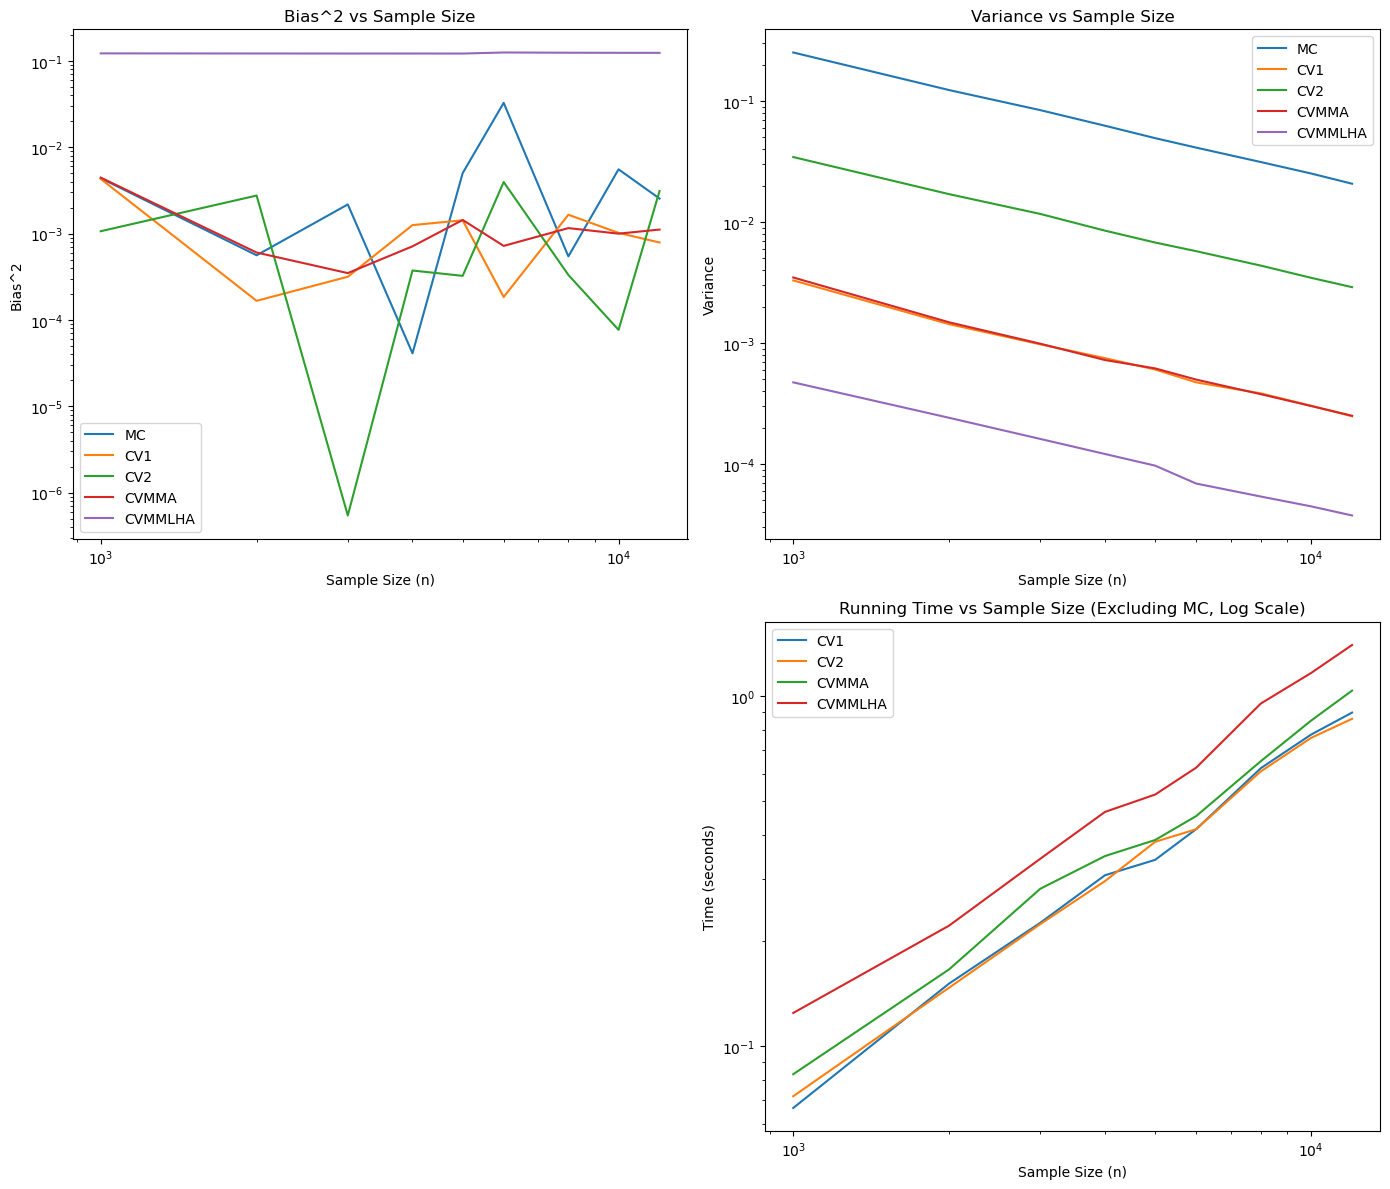

In [121]:
#CVMMA, CV1, CV2, CVMMLHA, MC 비교
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

barrier_flag = 'UpIn'
optionflag = 'call'
s = 100
k = 95
b = 110
r = 0.03
q = 0
t = 1
sigma = 0.2
m = 2000  # 줄여서 실행할 수도 있습니다 (예: 1000)
def analytic_barrier_price(s, k, b, r, t, sigma):
    rebate = 0
    barrierType = ql.Barrier.UpIn
    optionType = ql.Option.Call

    #Barrier Option
    today = ql.Date().todaysDate()
    maturity = today + ql.Period(t, ql.Years)

    payoff = ql.PlainVanillaPayoff(optionType, k)
    euExercise = ql.EuropeanExercise(maturity)
    barrierOption = ql.BarrierOption(barrierType, b, rebate, payoff, euExercise)

    #Market
    spotHandle = ql.QuoteHandle(ql.SimpleQuote(s))
    flatRateTs = ql.YieldTermStructureHandle(ql.FlatForward(today, r, ql.Actual365Fixed()))
    flatVolTs = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, ql.NullCalendar(), sigma, ql.Actual365Fixed()))
    bsm = ql.BlackScholesProcess(spotHandle, flatRateTs, flatVolTs)
    analyticBarrierEngine = ql.AnalyticBarrierEngine(bsm)

    #Pricing
    barrierOption.setPricingEngine(analyticBarrierEngine)
    price_as = barrierOption.NPV()
    return price_as

# Function list (assume barrier pricing functions are defined)
functions = [
    ("MC", mc_barrier_price),
    ("CV1", CV1_barrier_price),
    ("CV2", CV2_barrier_price),
    ("CVMMA", CVMMA_barrier_price),
    ("CVMMLHA", CVMMLHA_barrier_price)
]

n_values = [1000, 2000, 3000, 4000, 5000, 6000, 8000, 10000, 12000] # n 값을 줄여서 테스트
n_trials = 5

# Placeholder for analytic price
price_as = analytic_barrier_price(s, k, b, r, t, sigma)

# Data storage for results
results = {method: {"Bias^2": [], "Variance": [], "MSE": [], "Time": [], "n": []} for method, _ in functions}

# Perform evaluations
for n in n_values:
    for method_name, method_func in functions:
        prices = []
        variances = []
        times = []
        
        for _ in range(n_trials):
            start_time = time.time()
            price, se = method_func(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
            end_time = time.time()
            
            prices.append(price)
            variances.append(se**2)
            times.append(end_time - start_time)
        
        mean_price = np.mean(prices)
        bias_sq = (mean_price - price_as) ** 2
        variance = np.mean(variances)
        mse = bias_sq + variance
        avg_time = np.mean(times)
        
        results[method_name]["Bias^2"].append(bias_sq)
        results[method_name]["Variance"].append(variance)
        results[method_name]["MSE"].append(mse)
        results[method_name]["Time"].append(avg_time)
        results[method_name]["n"].append(n)

# Plotting
plt.figure(figsize=(14, 12))

# Absolute Bias plot
plt.subplot(2, 2, 1)
for method_name in results:
    plt.plot(results[method_name]["n"], results[method_name]["Bias^2"], label=method_name)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Sample Size (n)")
plt.ylabel("Bias^2")
plt.title("Bias^2 vs Sample Size")
plt.legend()

# Standard Error plot
plt.subplot(2, 2, 2)
for method_name in results:
    plt.plot(results[method_name]["n"], results[method_name]["Variance"], label=method_name)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Sample Size (n)")
plt.ylabel("Variance")
plt.title("Variance vs Sample Size")
plt.legend()

# Time Efficiency plot (excluding MC) with y-axis in log scale
plt.subplot(2, 2, 4)
for method_name in results:
    if method_name != "MC":  # Exclude MC from the plot
        plt.plot(results[method_name]["n"], results[method_name]["Time"], label=method_name)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Sample Size (n)")
plt.ylabel("Time (seconds)")
plt.title("Running Time vs Sample Size (Excluding MC, Log Scale)")
plt.legend()

plt.tight_layout()
plt.show()


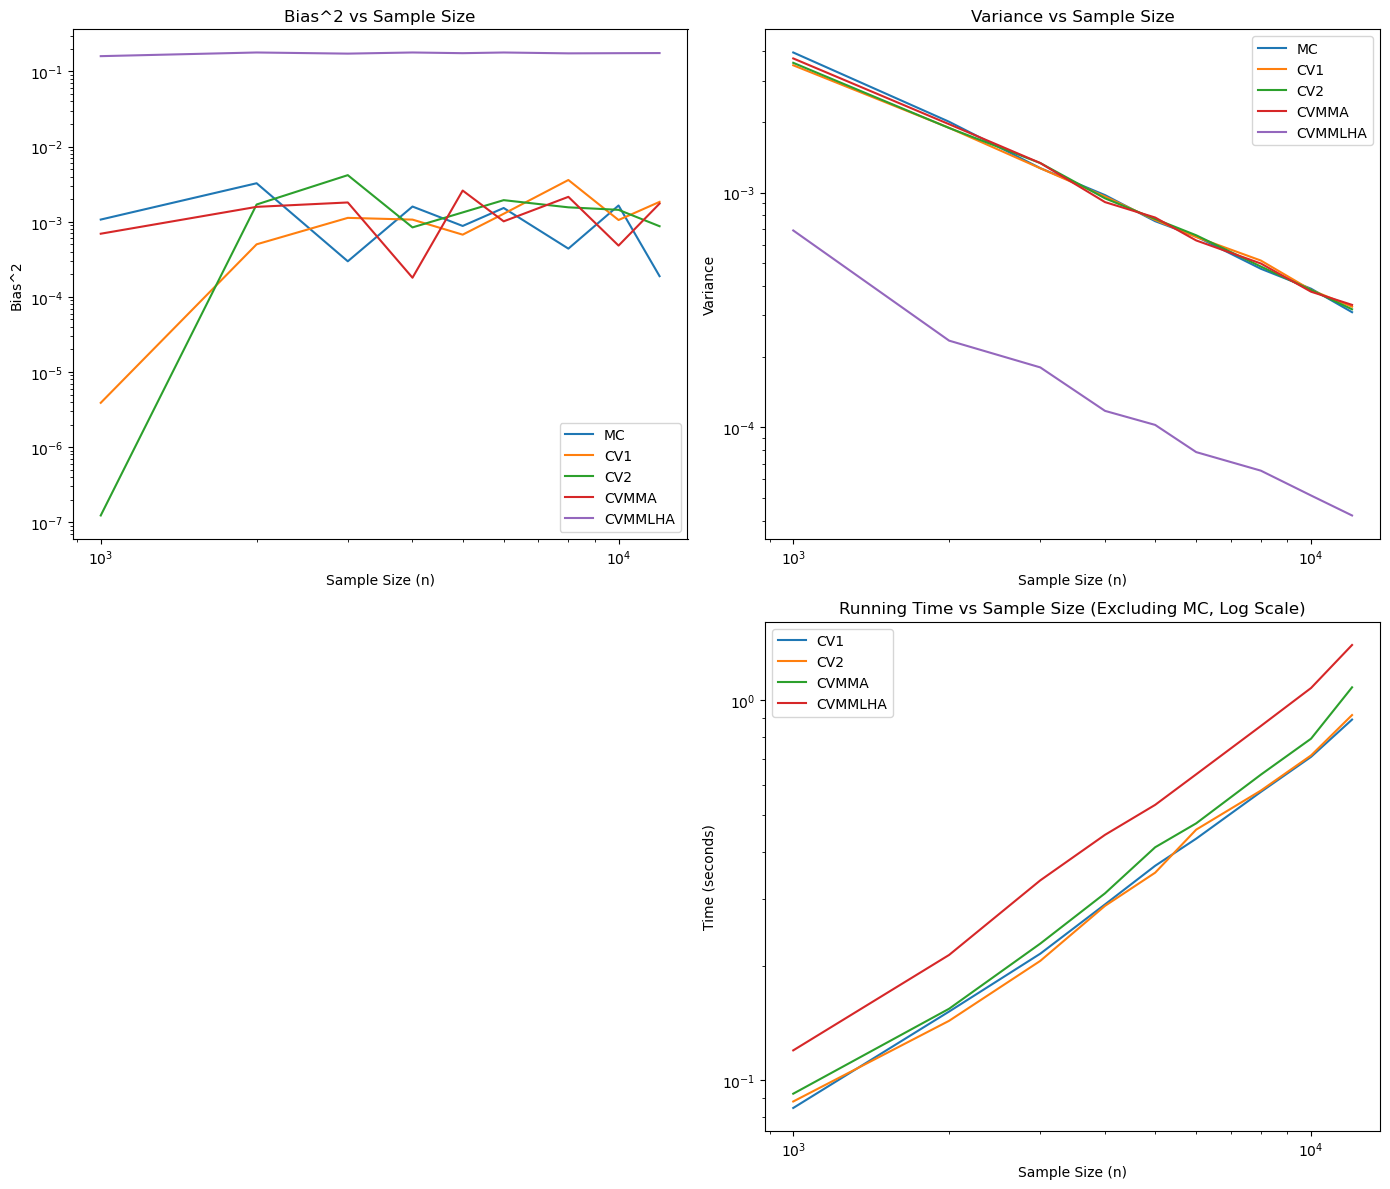

In [123]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

barrier_flag = 'DownOut'
optionflag = 'put'
s = 100
k = 105
b = 90
r = 0.03
q = 0
t = 1
sigma = 0.2
m = 2000  # 줄여서 실행할 수도 있습니다 (예: 1000)
def analytic_barrier_price(s, k, b, r, t, sigma):
    rebate = 0
    barrierType = ql.Barrier.DownOut
    optionType = ql.Option.Put

    #Barrier Option
    today = ql.Date().todaysDate()
    maturity = today + ql.Period(t, ql.Years)

    payoff = ql.PlainVanillaPayoff(optionType, k)
    euExercise = ql.EuropeanExercise(maturity)
    barrierOption = ql.BarrierOption(barrierType, b, rebate, payoff, euExercise)

    #Market
    spotHandle = ql.QuoteHandle(ql.SimpleQuote(s))
    flatRateTs = ql.YieldTermStructureHandle(ql.FlatForward(today, r, ql.Actual365Fixed()))
    flatVolTs = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, ql.NullCalendar(), sigma, ql.Actual365Fixed()))
    bsm = ql.BlackScholesProcess(spotHandle, flatRateTs, flatVolTs)
    analyticBarrierEngine = ql.AnalyticBarrierEngine(bsm)

    #Pricing
    barrierOption.setPricingEngine(analyticBarrierEngine)
    price_as = barrierOption.NPV()
    return price_as

# Function list (assume barrier pricing functions are defined)
functions = [
    ("MC", mc_barrier_price),
    ("CV1", CV1_barrier_price),
    ("CV2", CV2_barrier_price),
    ("CVMMA", CVMMA_barrier_price),
    ("CVMMLHA", CVMMLHA_barrier_price)
]

n_values = [1000, 2000, 3000, 4000, 5000, 6000, 8000, 10000, 12000] # n 값을 줄여서 테스트
n_trials = 5

# Placeholder for analytic price
price_as = analytic_barrier_price(s, k, b, r, t, sigma)

# Data storage for results
results = {method: {"Bias^2": [], "Variance": [], "MSE": [], "Time": [], "n": []} for method, _ in functions}

# Perform evaluations
for n in n_values:
    for method_name, method_func in functions:
        prices = []
        variances = []
        times = []
        
        for _ in range(n_trials):
            start_time = time.time()
            price, se = method_func(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
            end_time = time.time()
            
            prices.append(price)
            variances.append(se**2)
            times.append(end_time - start_time)
        
        mean_price = np.mean(prices)
        bias_sq = (mean_price - price_as) ** 2
        variance = np.mean(variances)
        mse = bias_sq + variance
        avg_time = np.mean(times)
        
        results[method_name]["Bias^2"].append(bias_sq)
        results[method_name]["Variance"].append(variance)
        results[method_name]["MSE"].append(mse)
        results[method_name]["Time"].append(avg_time)
        results[method_name]["n"].append(n)

# Plotting
plt.figure(figsize=(14, 12))

# Absolute Bias plot
plt.subplot(2, 2, 1)
for method_name in results:
    plt.plot(results[method_name]["n"], results[method_name]["Bias^2"], label=method_name)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Sample Size (n)")
plt.ylabel("Bias^2")
plt.title("Bias^2 vs Sample Size")
plt.legend()

# Standard Error plot
plt.subplot(2, 2, 2)
for method_name in results:
    plt.plot(results[method_name]["n"], results[method_name]["Variance"], label=method_name)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Sample Size (n)")
plt.ylabel("Variance")
plt.title("Variance vs Sample Size")
plt.legend()

# Time Efficiency plot (excluding MC) with y-axis in log scale
plt.subplot(2, 2, 4)
for method_name in results:
    if method_name != "MC":  # Exclude MC from the plot
        plt.plot(results[method_name]["n"], results[method_name]["Time"], label=method_name)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Sample Size (n)")
plt.ylabel("Time (seconds)")
plt.title("Running Time vs Sample Size (Excluding MC, Log Scale)")
plt.legend()

plt.tight_layout()
plt.show()

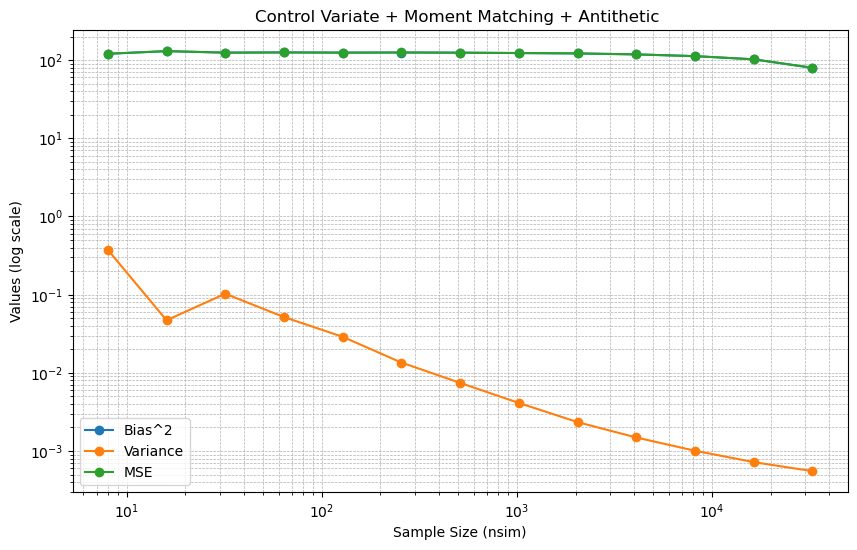

In [130]:
import numpy as np
import matplotlib.pyplot as plt
barrier_flag = 'UpIn'
optionflag = 'call'
s = 100
k = 95
b = 110
r = 0.03
q = 0
t = 1
sigma = 0.2
m = 2000  # 줄여서 실행할 수도 있습니다 (예: 1000)
def analytic_barrier_price(s, k, b, r, t, sigma):
    rebate = 0
    barrierType = ql.Barrier.UpIn
    optionType = ql.Option.Call

    #Barrier Option
    today = ql.Date().todaysDate()
    maturity = today + ql.Period(t, ql.Years)

    payoff = ql.PlainVanillaPayoff(optionType, k)
    euExercise = ql.EuropeanExercise(maturity)
    barrierOption = ql.BarrierOption(barrierType, b, rebate, payoff, euExercise)

    #Market
    spotHandle = ql.QuoteHandle(ql.SimpleQuote(s))
    flatRateTs = ql.YieldTermStructureHandle(ql.FlatForward(today, r, ql.Actual365Fixed()))
    flatVolTs = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, ql.NullCalendar(), sigma, ql.Actual365Fixed()))
    bsm = ql.BlackScholesProcess(spotHandle, flatRateTs, flatVolTs)
    analyticBarrierEngine = ql.AnalyticBarrierEngine(bsm)

    #Pricing
    barrierOption.setPricingEngine(analyticBarrierEngine)
    price_as = barrierOption.NPV()
    return price_as

# Placeholder for analytic price
price_as = analytic_barrier_price(s, k, b, r, t, sigma)
# Constants and parameters
C = 2**16  # 계산 예산
x = range(3, 16)  # nsim의 지수 범위
n_values = [2**i for i in x]
A = 100
analytic_price = price_as  # Example analytic price

# Data storage
bias_data = []
variance_data = []
mse_data = []

# Evaluation loop
for n in n_values:
    m = int(C / n)  # 각 nsim에 따른 시뮬레이션 반복 수
    prices = []
    ses = []
    for _ in range(10):  # 10번 반복하여 평균을 계산
        price_CVMMA, se_CVMMA = CVMMA_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
        prices.append(price_CVMMA)
        ses.append(se_CVMMA)

    # 평균 가격과 분산 계산
    mean_price = np.mean(prices)
    bias_sq = (mean_price - analytic_price) ** 2
    se1 = np.mean(ses)
    variance = se1 ** 2
    mse = bias_sq + variance

    # 저장
    bias_data.append(bias_sq)
    variance_data.append(variance)
    mse_data.append(mse)

# Plotting
plt.figure(figsize=(10, 6))

# Plot bias^2, variance, and MSE on the same graph with log scale
plt.plot(n_values, bias_data, label='Bias^2', marker='o')
plt.plot(n_values, variance_data, label='Variance', marker='o')
plt.plot(n_values, mse_data, label='MSE', marker='o')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Sample Size (nsim)')
plt.ylabel('Values (log scale)')
plt.title('Control Variate + Moment Matching + Antithetic ')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)

plt.show()


### 비교

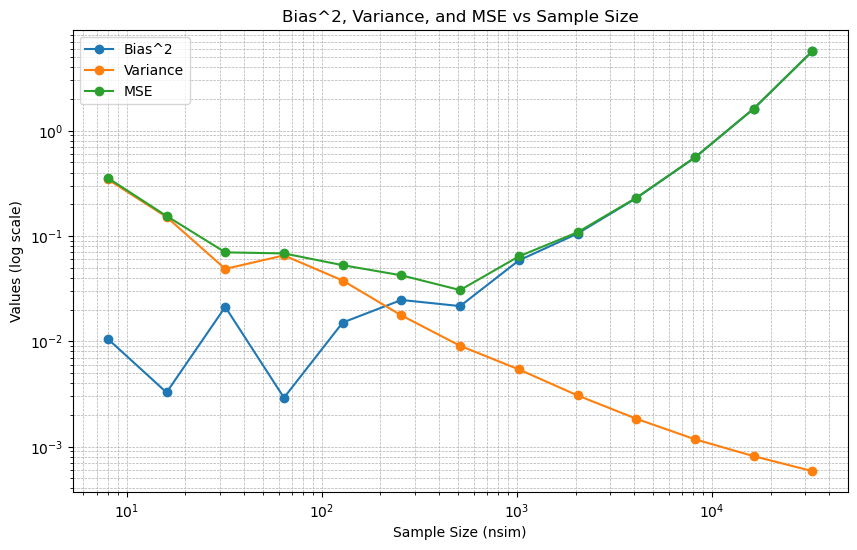

In [133]:
import numpy as np
import matplotlib.pyplot as plt
barrier_flag = 'UpIn'
optionflag = 'call'
s = 100
k = 95
b = 110
r = 0.03
q = 0
t = 1
sigma = 0.2
m = 2000  # 줄여서 실행할 수도 있습니다 (예: 1000)
def analytic_barrier_price(s, k, b, r, t, sigma):
    rebate = 0
    barrierType = ql.Barrier.UpIn
    optionType = ql.Option.Call

    #Barrier Option
    today = ql.Date().todaysDate()
    maturity = today + ql.Period(t, ql.Years)

    payoff = ql.PlainVanillaPayoff(optionType, k)
    euExercise = ql.EuropeanExercise(maturity)
    barrierOption = ql.BarrierOption(barrierType, b, rebate, payoff, euExercise)

    #Market
    spotHandle = ql.QuoteHandle(ql.SimpleQuote(s))
    flatRateTs = ql.YieldTermStructureHandle(ql.FlatForward(today, r, ql.Actual365Fixed()))
    flatVolTs = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, ql.NullCalendar(), sigma, ql.Actual365Fixed()))
    bsm = ql.BlackScholesProcess(spotHandle, flatRateTs, flatVolTs)
    analyticBarrierEngine = ql.AnalyticBarrierEngine(bsm)

    #Pricing
    barrierOption.setPricingEngine(analyticBarrierEngine)
    price_as = barrierOption.NPV()
    return price_as

# Placeholder for analytic price
price_as = analytic_barrier_price(s, k, b, r, t, sigma)
# Constants and parameters
C = 2**16  # 계산 예산
x = range(3, 16)  # nsim의 지수 범위
n_values = [2**i for i in x]
A = 100
analytic_price = price_as  # Example analytic price

# Data storage
bias_data = []
variance_data = []
mse_data = []

# Evaluation loop
for n in n_values:
    m = int(C / n)  # 각 nsim에 따른 시뮬레이션 반복 수
    prices = []
    ses = []
    for _ in range(10):  # 10번 반복하여 평균을 계산
        price, se = mc_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
        prices.append(price)
        ses.append(se)

    # 평균 가격과 분산 계산
    mean_price = np.mean(prices)
    bias_sq = (mean_price - analytic_price) ** 2
    se1 = np.mean(ses)
    variance = se1 ** 2
    mse = bias_sq + variance

    # 저장
    bias_data.append(bias_sq)
    variance_data.append(variance)
    mse_data.append(mse)

# Plotting
plt.figure(figsize=(10, 6))

# Plot bias^2, variance, and MSE on the same graph with log scale
plt.plot(n_values, bias_data, label='Bias^2', marker='o')
plt.plot(n_values, variance_data, label='Variance', marker='o')
plt.plot(n_values, mse_data, label='MSE', marker='o')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Sample Size (nsim)')
plt.ylabel('Values (log scale)')
plt.title('Bias^2, Variance, and MSE vs Sample Size')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)

plt.show()


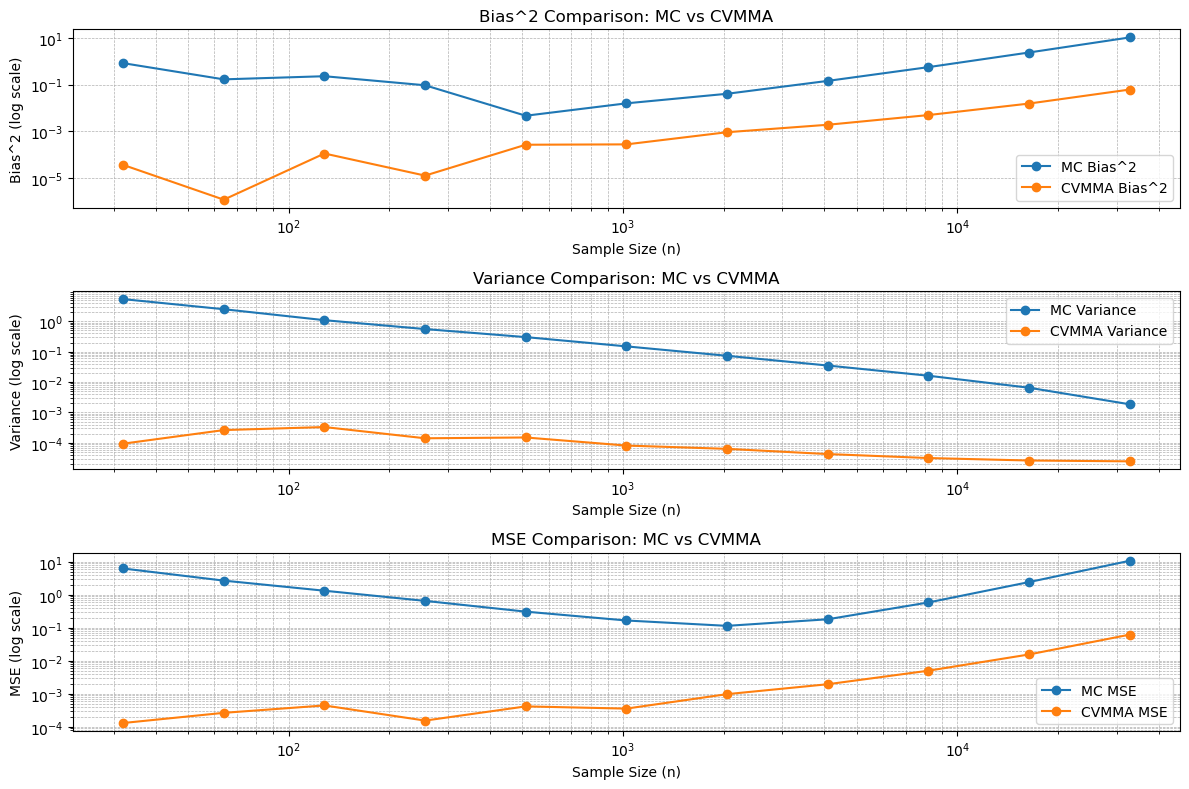

In [144]:
import numpy as np
import matplotlib.pyplot as plt
barrier_flag = 'UpIn'
optionflag = 'call'
s = 100
k = 105
b = 110
r = 0.03
q = 0
t = 1
sigma = 0.2
m = 2000  # 줄여서 실행할 수도 있습니다 (예: 1000)
def analytic_barrier_price(s, k, b, r, t, sigma):
    rebate = 0
    barrierType = ql.Barrier.UpIn
    optionType = ql.Option.Call

    #Barrier Option
    today = ql.Date().todaysDate()
    maturity = today + ql.Period(t, ql.Years)

    payoff = ql.PlainVanillaPayoff(optionType, k)
    euExercise = ql.EuropeanExercise(maturity)
    barrierOption = ql.BarrierOption(barrierType, b, rebate, payoff, euExercise)

    #Market
    spotHandle = ql.QuoteHandle(ql.SimpleQuote(s))
    flatRateTs = ql.YieldTermStructureHandle(ql.FlatForward(today, r, ql.Actual365Fixed()))
    flatVolTs = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, ql.NullCalendar(), sigma, ql.Actual365Fixed()))
    bsm = ql.BlackScholesProcess(spotHandle, flatRateTs, flatVolTs)
    analyticBarrierEngine = ql.AnalyticBarrierEngine(bsm)

    #Pricing
    barrierOption.setPricingEngine(analyticBarrierEngine)
    price_as = barrierOption.NPV()
    return price_as
price_as = analytic_barrier_price(s, k, b, r, t, sigma)
# Constants and parameters
C = 2**16  # 계산 예산
x = range(5, 16)  # nsim의 지수 범위
n_values = [2**i for i in x]
analytic_price = price_as  # Example analytic price

# Data storage for MC and CVMMA
results_mc = {'Bias^2': [], 'Variance': [], 'MSE': []}
results_cvmma = {'Bias^2': [], 'Variance': [], 'MSE': []}

# Evaluation loop for MC and CVMMA
for n in n_values:
    m = int(C / n)  # 각 nsim에 따른 시뮬레이션 반복 수
    
    # MC barrier method
    prices_mc = []
    ses_mc = []
    for _ in range(30):  # 10번 반복하여 평균을 계산
        price_mc, se_mc = mc_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
        prices_mc.append(price_mc)
        ses_mc.append(se_mc)

    mean_price_mc = np.mean(prices_mc)
    bias_sq_mc = (mean_price_mc - analytic_price) ** 2
    variance_mc = (np.mean(ses_mc)) ** 2
    mse_mc = bias_sq_mc + variance_mc

    results_mc['Bias^2'].append(bias_sq_mc)
    results_mc['Variance'].append(variance_mc)
    results_mc['MSE'].append(mse_mc)
    
    # CVMMA barrier method
    prices_cvmma = []
    ses_cvmma = []
    for _ in range(10):  # 10번 반복하여 평균을 계산
        price_cvmma, se_cvmma = CVMMA_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
        prices_cvmma.append(price_cvmma)
        ses_cvmma.append(se_cvmma)

    mean_price_cvmma = np.mean(prices_cvmma)
    bias_sq_cvmma = (mean_price_cvmma - analytic_price) ** 2
    variance_cvmma = (np.mean(ses_cvmma)) ** 2
    mse_cvmma = bias_sq_cvmma + variance_cvmma

    results_cvmma['Bias^2'].append(bias_sq_cvmma)
    results_cvmma['Variance'].append(variance_cvmma)
    results_cvmma['MSE'].append(mse_cvmma)

# Plotting comparison for MC and CVMMA
plt.figure(figsize=(12, 8))

# Bias^2 plot
plt.subplot(3, 1, 1)
plt.plot(n_values, results_mc['Bias^2'], label='MC Bias^2', marker='o')
plt.plot(n_values, results_cvmma['Bias^2'], label='CVMMA Bias^2', marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Sample Size (n)')
plt.ylabel('Bias^2 (log scale)')
plt.title('Bias^2 Comparison: MC vs CVMMA')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)

# Variance plot
plt.subplot(3, 1, 2)
plt.plot(n_values, results_mc['Variance'], label='MC Variance', marker='o')
plt.plot(n_values, results_cvmma['Variance'], label='CVMMA Variance', marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Sample Size (n)')
plt.ylabel('Variance (log scale)')
plt.title('Variance Comparison: MC vs CVMMA')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)

# MSE plot
plt.subplot(3, 1, 3)
plt.plot(n_values, results_mc['MSE'], label='MC MSE', marker='o')
plt.plot(n_values, results_cvmma['MSE'], label='CVMMA MSE', marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Sample Size (n)')
plt.ylabel('MSE (log scale)')
plt.title('MSE Comparison: MC vs CVMMA')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
barrier_flag = 'UpIn'
optionflag = 'call'
s = 100
k = 105
b = 110
r = 0.03
q = 0
t = 1
sigma = 0.2
m = 2000  # 줄여서 실행할 수도 있습니다 (예: 1000)
def analytic_barrier_price(s, k, b, r, t, sigma):
    rebate = 0
    barrierType = ql.Barrier.UpIn
    optionType = ql.Option.Call

    #Barrier Option
    today = ql.Date().todaysDate()
    maturity = today + ql.Period(t, ql.Years)

    payoff = ql.PlainVanillaPayoff(optionType, k)
    euExercise = ql.EuropeanExercise(maturity)
    barrierOption = ql.BarrierOption(barrierType, b, rebate, payoff, euExercise)

    #Market
    spotHandle = ql.QuoteHandle(ql.SimpleQuote(s))
    flatRateTs = ql.YieldTermStructureHandle(ql.FlatForward(today, r, ql.Actual365Fixed()))
    flatVolTs = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, ql.NullCalendar(), sigma, ql.Actual365Fixed()))
    bsm = ql.BlackScholesProcess(spotHandle, flatRateTs, flatVolTs)
    analyticBarrierEngine = ql.AnalyticBarrierEngine(bsm)

    #Pricing
    barrierOption.setPricingEngine(analyticBarrierEngine)
    price_as = barrierOption.NPV()
    return price_as
price_as = analytic_barrier_price(s, k, b, r, t, sigma)
# Constants and parameters
C = 2**16  # 계산 예산
x = range(5, 16)  # nsim의 지수 범위
n_values = [2**i for i in x]
analytic_price = price_as  # Example analytic price

# Data storage for MC and CVMMA
results_mc = {'Bias^2': [], 'Variance': [], 'MSE': []}
results_cvmma = {'Bias^2': [], 'Variance': [], 'MSE': []}

# Evaluation loop for MC and CVMMA
for n in n_values:
    m = int(C / n)  # 각 nsim에 따른 시뮬레이션 반복 수
    
    # MC barrier method
    prices_mc = []
    ses_mc = []
    for _ in range(30):  # 10번 반복하여 평균을 계산
        price_mc, se_mc = mc_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
        prices_mc.append(price_mc)
        ses_mc.append(se_mc)

    mean_price_mc = np.mean(prices_mc)
    bias_sq_mc = (mean_price_mc - analytic_price) ** 2
    variance_mc = (np.mean(ses_mc)) ** 2
    mse_mc = bias_sq_mc + variance_mc

    results_mc['Bias^2'].append(bias_sq_mc)
    results_mc['Variance'].append(variance_mc)
    results_mc['MSE'].append(mse_mc)
    
    # CVMMA barrier method
    prices_cvmma = []
    ses_cvmma = []
    for _ in range(10):  # 10번 반복하여 평균을 계산
        price_cvmma, se_cvmma = CVMMLHA_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
        prices_cvmma.append(price_cvmma)
        ses_cvmma.append(se_cvmma)

    mean_price_cvmma = np.mean(prices_cvmma)
    bias_sq_cvmma = (mean_price_cvmma - analytic_price) ** 2
    variance_cvmma = (np.mean(ses_cvmma)) ** 2
    mse_cvmma = bias_sq_cvmma + variance_cvmma

    results_cvmma['Bias^2'].append(bias_sq_cvmma)
    results_cvmma['Variance'].append(variance_cvmma)
    results_cvmma['MSE'].append(mse_cvmma)

# Plotting comparison for MC and CVMMA
plt.figure(figsize=(12, 8))

# Bias^2 plot
plt.subplot(3, 1, 1)
plt.plot(n_values, results_mc['Bias^2'], label='MC Bias^2', marker='o')
plt.plot(n_values, results_cvmma['Bias^2'], label='CVMMA Bias^2', marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Sample Size (n)')
plt.ylabel('Bias^2 (log scale)')
plt.title('Bias^2 Comparison: MC vs CVMMA')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)

# Variance plot
plt.subplot(3, 1, 2)
plt.plot(n_values, results_mc['Variance'], label='MC Variance', marker='o')
plt.plot(n_values, results_cvmma['Variance'], label='CVMMA Variance', marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Sample Size (n)')
plt.ylabel('Variance (log scale)')
plt.title('Variance Comparison: MC vs CVMMA')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)

# MSE plot
plt.subplot(3, 1, 3)
plt.plot(n_values, results_mc['MSE'], label='MC MSE', marker='o')
plt.plot(n_values, results_cvmma['MSE'], label='CVMMA MSE', marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Sample Size (n)')
plt.ylabel('MSE (log scale)')
plt.title('MSE Comparison: MC vs CVMMA')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)

plt.tight_layout()
plt.show()

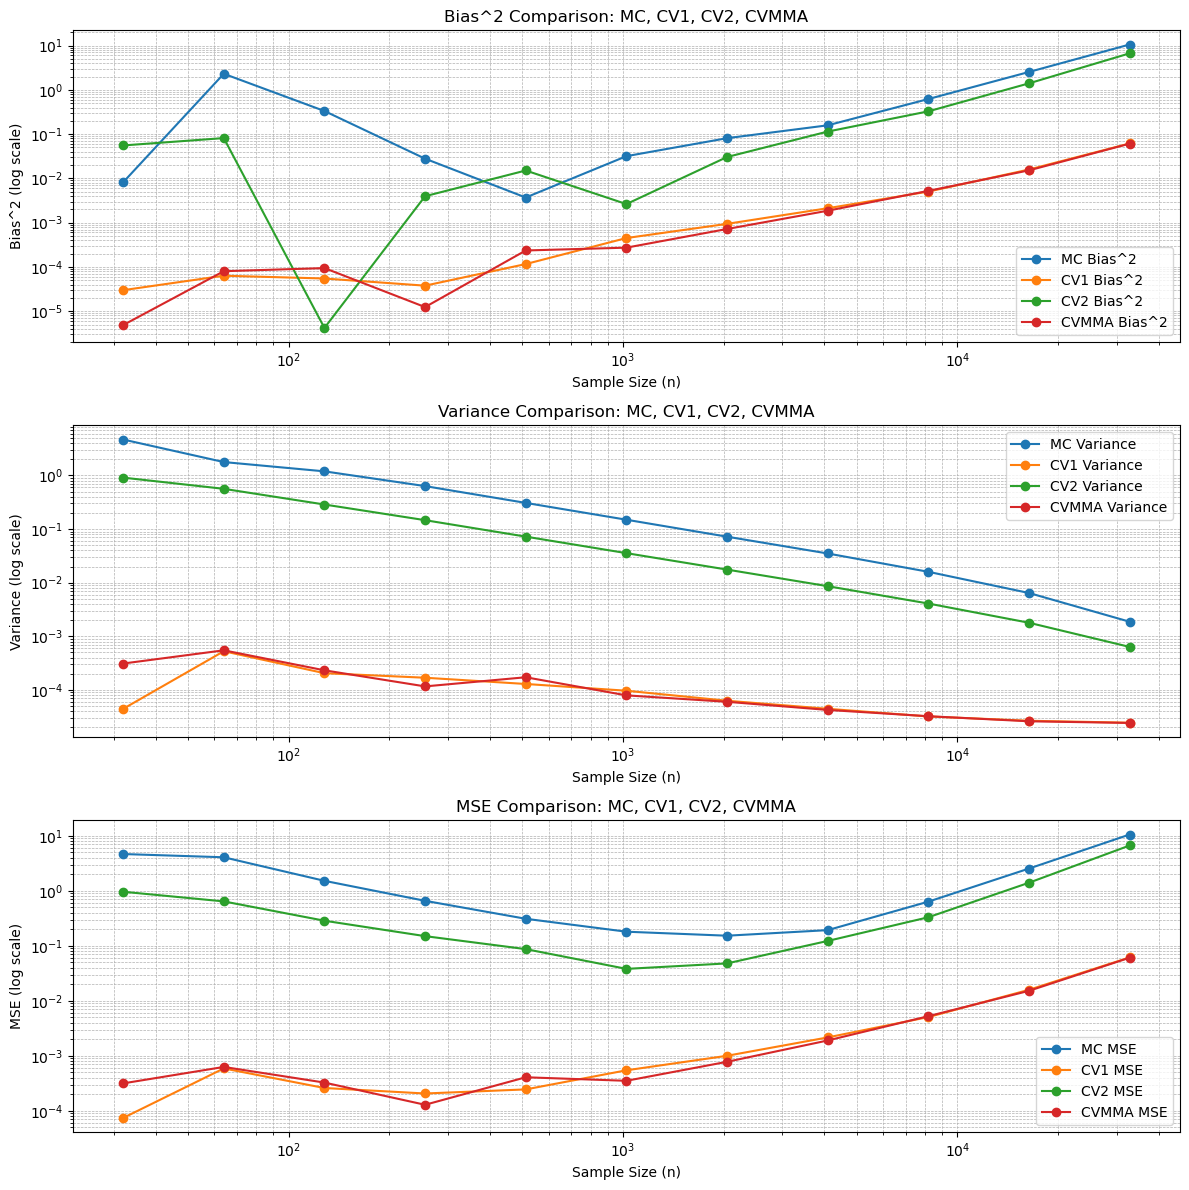

In [150]:
import numpy as np
import matplotlib.pyplot as plt

# Constants and parameters
C = 2**16  # 계산 예산
x = range(5, 16)  # nsim의 지수 범위
n_values = [2**i for i in x]
analytic_price = price_as  # Analytic price 계산 값

# Data storage for MC, CV1, CV2, and CVMMA
results_mc = {'Bias^2': [], 'Variance': [], 'MSE': []}
results_cv1 = {'Bias^2': [], 'Variance': [], 'MSE': []}
results_cv2 = {'Bias^2': [], 'Variance': [], 'MSE': []}
results_cvmma = {'Bias^2': [], 'Variance': [], 'MSE': []}

# Evaluation loop for each method
for n in n_values:
    m = int(C / n)  # 각 nsim에 따른 시뮬레이션 반복 수
    
    # MC barrier method
    prices_mc = []
    ses_mc = []
    for _ in range(10):  # 10번 반복하여 평균을 계산
        price_mc, se_mc = mc_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
        prices_mc.append(price_mc)
        ses_mc.append(se_mc)

    mean_price_mc = np.mean(prices_mc)
    bias_sq_mc = (mean_price_mc - analytic_price) ** 2
    variance_mc = (np.mean(ses_mc)) ** 2
    mse_mc = bias_sq_mc + variance_mc

    results_mc['Bias^2'].append(bias_sq_mc)
    results_mc['Variance'].append(variance_mc)
    results_mc['MSE'].append(mse_mc)
    
    # CV1 barrier method
    prices_cv1 = []
    ses_cv1 = []
    for _ in range(10):
        price_cv1, se_cv1 = CV1_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
        prices_cv1.append(price_cv1)
        ses_cv1.append(se_cv1)

    mean_price_cv1 = np.mean(prices_cv1)
    bias_sq_cv1 = (mean_price_cv1 - analytic_price) ** 2
    variance_cv1 = (np.mean(ses_cv1)) ** 2
    mse_cv1 = bias_sq_cv1 + variance_cv1

    results_cv1['Bias^2'].append(bias_sq_cv1)
    results_cv1['Variance'].append(variance_cv1)
    results_cv1['MSE'].append(mse_cv1)

    # CV2 barrier method
    prices_cv2 = []
    ses_cv2 = []
    for _ in range(10):
        price_cv2, se_cv2 = CV2_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
        prices_cv2.append(price_cv2)
        ses_cv2.append(se_cv2)

    mean_price_cv2 = np.mean(prices_cv2)
    bias_sq_cv2 = (mean_price_cv2 - analytic_price) ** 2
    variance_cv2 = (np.mean(ses_cv2)) ** 2
    mse_cv2 = bias_sq_cv2 + variance_cv2

    results_cv2['Bias^2'].append(bias_sq_cv2)
    results_cv2['Variance'].append(variance_cv2)
    results_cv2['MSE'].append(mse_cv2)

    # CVMMA barrier method
    prices_cvmma = []
    ses_cvmma = []
    for _ in range(10):
        price_cvmma, se_cvmma = CVMMA_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
        prices_cvmma.append(price_cvmma)
        ses_cvmma.append(se_cvmma)

    mean_price_cvmma = np.mean(prices_cvmma)
    bias_sq_cvmma = (mean_price_cvmma - analytic_price) ** 2
    variance_cvmma = (np.mean(ses_cvmma)) ** 2
    mse_cvmma = bias_sq_cvmma + variance_cvmma

    results_cvmma['Bias^2'].append(bias_sq_cvmma)
    results_cvmma['Variance'].append(variance_cvmma)
    results_cvmma['MSE'].append(mse_cvmma)

# Plotting comparison for MC, CV1, CV2, and CVMMA
plt.figure(figsize=(12, 12))

# Bias^2 plot
plt.subplot(3, 1, 1)
plt.plot(n_values, results_mc['Bias^2'], label='MC Bias^2', marker='o')
plt.plot(n_values, results_cv1['Bias^2'], label='CV1 Bias^2', marker='o')
plt.plot(n_values, results_cv2['Bias^2'], label='CV2 Bias^2', marker='o')
plt.plot(n_values, results_cvmma['Bias^2'], label='CVMMA Bias^2', marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Sample Size (n)')
plt.ylabel('Bias^2 (log scale)')
plt.title('Bias^2 Comparison: MC, CV1, CV2, CVMMA')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)

# Variance plot
plt.subplot(3, 1, 2)
plt.plot(n_values, results_mc['Variance'], label='MC Variance', marker='o')
plt.plot(n_values, results_cv1['Variance'], label='CV1 Variance', marker='o')
plt.plot(n_values, results_cv2['Variance'], label='CV2 Variance', marker='o')
plt.plot(n_values, results_cvmma['Variance'], label='CVMMA Variance', marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Sample Size (n)')
plt.ylabel('Variance (log scale)')
plt.title('Variance Comparison: MC, CV1, CV2, CVMMA')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)

# MSE plot
plt.subplot(3, 1, 3)
plt.plot(n_values, results_mc['MSE'], label='MC MSE', marker='o')
plt.plot(n_values, results_cv1['MSE'], label='CV1 MSE', marker='o')
plt.plot(n_values, results_cv2['MSE'], label='CV2 MSE', marker='o')
plt.plot(n_values, results_cvmma['MSE'], label='CVMMA MSE', marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Sample Size (n)')
plt.ylabel('MSE (log scale)')
plt.title('MSE Comparison: MC, CV1, CV2, CVMMA')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)

plt.tight_layout()
plt.show()


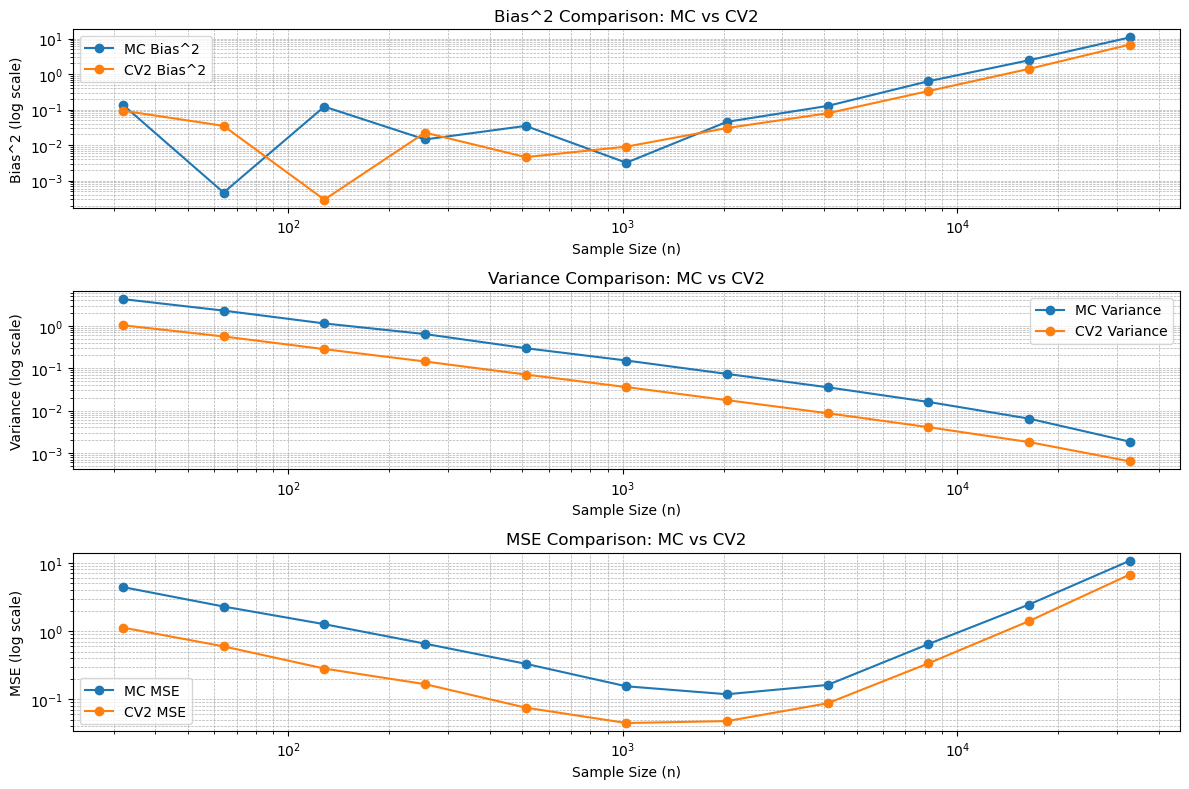

In [149]:
import numpy as np
import matplotlib.pyplot as plt
barrier_flag = 'UpIn'
optionflag = 'call'
s = 100
k = 105
b = 110
r = 0.03
q = 0
t = 1
sigma = 0.2
m = 2000  # 줄여서 실행할 수도 있습니다 (예: 1000)
def analytic_barrier_price(s, k, b, r, t, sigma):
    rebate = 0
    barrierType = ql.Barrier.UpIn
    optionType = ql.Option.Call

    #Barrier Option
    today = ql.Date().todaysDate()
    maturity = today + ql.Period(t, ql.Years)

    payoff = ql.PlainVanillaPayoff(optionType, k)
    euExercise = ql.EuropeanExercise(maturity)
    barrierOption = ql.BarrierOption(barrierType, b, rebate, payoff, euExercise)

    #Market
    spotHandle = ql.QuoteHandle(ql.SimpleQuote(s))
    flatRateTs = ql.YieldTermStructureHandle(ql.FlatForward(today, r, ql.Actual365Fixed()))
    flatVolTs = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, ql.NullCalendar(), sigma, ql.Actual365Fixed()))
    bsm = ql.BlackScholesProcess(spotHandle, flatRateTs, flatVolTs)
    analyticBarrierEngine = ql.AnalyticBarrierEngine(bsm)

    #Pricing
    barrierOption.setPricingEngine(analyticBarrierEngine)
    price_as = barrierOption.NPV()
    return price_as
price_as = analytic_barrier_price(s, k, b, r, t, sigma)
# Constants and parameters
C = 2**16  # 계산 예산
x = range(5, 16)  # nsim의 지수 범위
n_values = [2**i for i in x]
analytic_price = price_as  # Example analytic price

# Data storage for MC and CVMMA
results_mc = {'Bias^2': [], 'Variance': [], 'MSE': []}
results_cvmma = {'Bias^2': [], 'Variance': [], 'MSE': []}

# Evaluation loop for MC and CVMMA
for n in n_values:
    m = int(C / n)  # 각 nsim에 따른 시뮬레이션 반복 수
    
    # MC barrier method
    prices_mc = []
    ses_mc = []
    for _ in range(30):  # 10번 반복하여 평균을 계산
        price_mc, se_mc = mc_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
        prices_mc.append(price_mc)
        ses_mc.append(se_mc)

    mean_price_mc = np.mean(prices_mc)
    bias_sq_mc = (mean_price_mc - analytic_price) ** 2
    variance_mc = (np.mean(ses_mc)) ** 2
    mse_mc = bias_sq_mc + variance_mc

    results_mc['Bias^2'].append(bias_sq_mc)
    results_mc['Variance'].append(variance_mc)
    results_mc['MSE'].append(mse_mc)
    
    # CVMMA barrier method
    prices_cvmma = []
    ses_cvmma = []
    for _ in range(10):  # 10번 반복하여 평균을 계산
        price_cvmma, se_cvmma = CV2_barrier_price(s, k, b, r, q, t, sigma, optionflag, n, barrier_flag, m)
        prices_cvmma.append(price_cvmma)
        ses_cvmma.append(se_cvmma)

    mean_price_cvmma = np.mean(prices_cvmma)
    bias_sq_cvmma = (mean_price_cvmma - analytic_price) ** 2
    variance_cvmma = (np.mean(ses_cvmma)) ** 2
    mse_cvmma = bias_sq_cvmma + variance_cvmma

    results_cvmma['Bias^2'].append(bias_sq_cvmma)
    results_cvmma['Variance'].append(variance_cvmma)
    results_cvmma['MSE'].append(mse_cvmma)

# Plotting comparison for MC and CVMMA
plt.figure(figsize=(12, 8))

# Bias^2 plot
plt.subplot(3, 1, 1)
plt.plot(n_values, results_mc['Bias^2'], label='MC Bias^2', marker='o')
plt.plot(n_values, results_cvmma['Bias^2'], label='CV2 Bias^2', marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Sample Size (n)')
plt.ylabel('Bias^2 (log scale)')
plt.title('Bias^2 Comparison: MC vs CV2')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)

# Variance plot
plt.subplot(3, 1, 2)
plt.plot(n_values, results_mc['Variance'], label='MC Variance', marker='o')
plt.plot(n_values, results_cvmma['Variance'], label='CV2 Variance', marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Sample Size (n)')
plt.ylabel('Variance (log scale)')
plt.title('Variance Comparison: MC vs CV2')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)

# MSE plot
plt.subplot(3, 1, 3)
plt.plot(n_values, results_mc['MSE'], label='MC MSE', marker='o')
plt.plot(n_values, results_cvmma['MSE'], label='CV2 MSE', marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Sample Size (n)')
plt.ylabel('MSE (log scale)')
plt.title('MSE Comparison: MC vs CV2')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)

plt.tight_layout()
plt.show()

In [ ]:
# Remove "MC" and "CV2" from the data for visualization
mse_filtered_data = {
    "Method": ["CV1", "CVMMA", "CVMMLH", "CVMMLHA", "CVMMLHAIS"],
    "MSE (n=10000)": [0.00000502, 0.00000477, 0.00000376, 0.00000756, 0.00000427],
    "MSE (n=1000)": [0.00005022, 0.00004779, 0.00003761, 0.00007561, 0.00004273]
}

# Create a DataFrame to store the filtered data
mse_filtered_df = pd.DataFrame(mse_filtered_data)

# Plotting the MSE comparison chart without "MC" and "CV2"
plt.figure(figsize=(10, 6))

# Bar plot for each method and MSE at different n values
bar_width = 0.35
index = np.arange(len(mse_filtered_df["Method"]))

# Plot for MSE at n=10000
plt.bar(index, mse_filtered_df["MSE (n=10000)"], bar_width, label="n=10000")

# Plot for MSE at n=1000
plt.bar(index + bar_width, mse_filtered_df["MSE (n=1000)"], bar_width, label="n=1000")

# Adding labels and title
plt.xlabel("Method")
plt.ylabel("MSE")
plt.title("MSE Comparison of Barrier Option Pricing Methods (Excluding MC and CV2)")
plt.xticks(index + bar_width / 2, mse_filtered_df["Method"])
plt.legend()

# Display the plot
plt.show()
